<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW6_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [80]:
!pip3 install gdown -q


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import gdown

url = 'https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO'
output = 'Data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO
From (redirected): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO&confirm=t&uuid=0a1e568a-5f83-4a45-b597-05389c70e2a8
To: /Users/vitaly/Downloads/Data.zip
100%|██████████| 289M/289M [00:45<00:00, 6.38MB/s] 


'Data.zip'

In [3]:
import zipfile

with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

OSError: [Errno 30] Read-only file system: '/content'

<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h3> Contracts </h3> Таблица с покупками продуктов

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

<h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

### 1.1 Импорт 

In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [201]:
features = pd.read_csv('/Users/vitaly/Downloads/ДЗ по Uplift обновленное/AGGS_FINAL.csv')
campaigns = pd.read_csv('/Users/vitaly/Downloads/ДЗ по Uplift обновленное/CAMPAINGS.csv')
contracts = pd.read_csv('/Users/vitaly/Downloads/ДЗ по Uplift обновленное/CONTRACTS_FINAL.csv')
ppl_in_campaigns = pd.read_csv('/Users/vitaly/Downloads/ДЗ по Uplift обновленное/PEOPLE_IN_CAMPAINGS_FINAL.csv')

features.drop(columns=['Unnamed: 0'], inplace=True)
campaigns.drop(columns=['Unnamed: 0'], inplace=True)
contracts.drop(columns=['Unnamed: 0'], inplace=True)
ppl_in_campaigns.drop(columns=['Unnamed: 0'], inplace=True)

In [202]:
features.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city
0,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,2025-01-31,1066338,26,Ufa
1,2.583579,1.755569,3.360186,-1.122864,0.034201,-0.269607,-1.503646,1.040289,-1.691606,2024-11-30,13900,35,Ufa
2,0.296030,-0.937075,1.073280,1.874636,-0.981216,-1.100187,-0.331181,-1.575637,0.474965,2025-03-31,4063636,28,Ufa
3,2.329328,-1.345159,0.345066,0.755373,-0.082842,0.028439,0.919211,0.808793,-0.560004,2025-03-31,1025488,27,Moscow
4,0.167643,1.587099,0.165357,0.289758,-1.108840,-1.501819,0.615588,1.631203,-0.208419,2025-02-28,4040555,37,Moscow


In [ ]:
features['report_dt'] = pd.to_datetime(features['report_dt'])

In [204]:
campaigns.head()

,campaing_id,product_id,channel
0,iddqd,1,push
1,idclip,1,sms
2,iddt,1,banner
3,idkfa,1,other_ads


In [205]:
contracts.head()

,user_id,contract_date,product_id,contract_id
0,4008279,2024-11-03,1,0001_2024-11-03_4008279
1,2079035,2024-11-08,1,0001_2024-11-08_2079035
2,103088,2024-11-13,1,0001_2024-11-13_103088
3,2026788,2024-11-02,1,0001_2024-11-02_2026788
4,52269,2024-11-17,1,0001_2024-11-17_52269


In [ ]:
contracts['contract_date'] = pd.to_datetime(contracts['contract_date'])

In [207]:
ppl_in_campaigns.head()

,campaing_id,user_id,t_flag,delivery_date
0,idclip,1099975,1,2024-11-06
1,iddqd,1162,1,2024-11-08
2,iddqd,42991,1,2024-11-07
3,idclip,142343,0,unknown
4,iddqd,24623,0,unknown


### 1.2 Поиск некорректных кампаний

Выполнен далее после объединения нескольких таблиц

### 1.3 Merge Таблиц

В основе целевого действия определенный продукт (0001), поэтому основной таблицей будет CONTRACTS \
Затем присоединим к ней информацию о людях в компании и отфильтруем по дате (дата покупки >= дата доставки рекламной компании)

In [208]:
# покупки продукта 1
contracts_product_1 = contracts.query('product_id == 1')
contracts_product_1

,user_id,contract_date,product_id,contract_id
0,4008279,2024-11-03,1,0001_2024-11-03_4008279
1,2079035,2024-11-08,1,0001_2024-11-08_2079035
2,103088,2024-11-13,1,0001_2024-11-13_103088
3,2026788,2024-11-02,1,0001_2024-11-02_2026788
4,52269,2024-11-17,1,0001_2024-11-17_52269
...,...,...,...,...
286311,1117397,2024-11-28,1,0001_2024-11-28_1117397
286312,2071348,2024-11-12,1,0001_2024-11-12_2071348
286313,4061197,2024-11-07,1,0001_2024-11-07_4061197
286314,1139038,2024-11-02,1,0001_2024-11-02_1139038


In [ ]:
# покупки + люди в кампаниях (люди в кампаниях в основе, поэтому right join)
contr_ppl_camp = contracts_product_1.merge(ppl_in_campaigns,
                                           on='user_id',
                                           how='right')
contr_ppl_camp

,user_id,contract_date,product_id,contract_id,campaing_id,t_flag,delivery_date
0,1099975,2024-11-11,1.0,0001_2024-11-11_1099975,idclip,1,2024-11-06
1,1162,2024-11-13,1.0,0001_2024-11-13_1162,iddqd,1,2024-11-08
2,42991,NaT,NaN,NaN,iddqd,1,2024-11-07
3,142343,2024-11-17,1.0,0001_2024-11-17_142343,idclip,0,unknown
4,24623,NaT,NaN,NaN,iddqd,0,unknown
...,...,...,...,...,...,...,...
519995,4108275,2024-11-15,1.0,0001_2024-11-15_4108275,iddt,1,2024-11-04
519996,131927,2024-11-27,1.0,0001_2024-11-27_131927,iddqd,1,2024-11-06
519997,1074765,NaT,NaN,NaN,idclip,1,2024-11-05
519998,73995,NaT,NaN,NaN,iddqd,0,unknown


Добавим столбец с датой начала месяца, в который совершена покупка для людей из контрольной группы (для проверки кол-во недель с начала рекламной компании), или дата получение действия рекламной компании. Если покупки не было (NA), то ставим старую дату, чтобы разница дат потом была огромная и под условие покупки ни для одной из категорий не попало.

In [210]:
def create_date_column(row):
    if row['delivery_date'] == 'unknown':
        if pd.isna(row['contract_date']):
            return pd.to_datetime('1990-01-01')
        else:
            return row['contract_date'].to_period('M').start_time
    else:
        return pd.to_datetime(row['delivery_date'])

In [211]:
contr_ppl_camp['all_dates'] = contr_ppl_camp.apply(create_date_column, axis=1)

In [212]:
contr_ppl_camp

,user_id,contract_date,product_id,contract_id,campaing_id,t_flag,delivery_date,all_dates
0,1099975,2024-11-11,1.0,0001_2024-11-11_1099975,idclip,1,2024-11-06,2024-11-06
1,1162,2024-11-13,1.0,0001_2024-11-13_1162,iddqd,1,2024-11-08,2024-11-08
2,42991,NaT,NaN,NaN,iddqd,1,2024-11-07,2024-11-07
3,142343,2024-11-17,1.0,0001_2024-11-17_142343,idclip,0,unknown,2024-11-01
4,24623,NaT,NaN,NaN,iddqd,0,unknown,1990-01-01
...,...,...,...,...,...,...,...,...
519995,4108275,2024-11-15,1.0,0001_2024-11-15_4108275,iddt,1,2024-11-04,2024-11-04
519996,131927,2024-11-27,1.0,0001_2024-11-27_131927,iddqd,1,2024-11-06,2024-11-06
519997,1074765,NaT,NaN,NaN,idclip,1,2024-11-05,2024-11-05
519998,73995,NaT,NaN,NaN,iddqd,0,unknown,1990-01-01


Добавим флаг с проверкой того, что дата покупки после даты получения действия рекламной компании. 1 - корректно; 0 - НЕкорректно

In [213]:
def check_date_seq(row):
    if pd.isna(row['contract_date']):
        return 1
    else:
        if row['contract_date'] >= row['all_dates']:
            return 1
        else:
            return 0

In [214]:
contr_ppl_camp['corr_date_seq'] = contr_ppl_camp.apply(check_date_seq, axis=1)

In [215]:
contr_ppl_camp

,user_id,contract_date,product_id,contract_id,campaing_id,t_flag,delivery_date,all_dates,corr_date_seq
0,1099975,2024-11-11,1.0,0001_2024-11-11_1099975,idclip,1,2024-11-06,2024-11-06,1
1,1162,2024-11-13,1.0,0001_2024-11-13_1162,iddqd,1,2024-11-08,2024-11-08,1
2,42991,NaT,NaN,NaN,iddqd,1,2024-11-07,2024-11-07,1
3,142343,2024-11-17,1.0,0001_2024-11-17_142343,idclip,0,unknown,2024-11-01,1
4,24623,NaT,NaN,NaN,iddqd,0,unknown,1990-01-01,1
...,...,...,...,...,...,...,...,...,...
519995,4108275,2024-11-15,1.0,0001_2024-11-15_4108275,iddt,1,2024-11-04,2024-11-04,1
519996,131927,2024-11-27,1.0,0001_2024-11-27_131927,iddqd,1,2024-11-06,2024-11-06,1
519997,1074765,NaT,NaN,NaN,idclip,1,2024-11-05,2024-11-05,1
519998,73995,NaT,NaN,NaN,iddqd,0,unknown,1990-01-01,1


In [216]:
# записи с корректной последовательностью событий
contr_ppl_camp_cor = contr_ppl_camp.query('corr_date_seq == 1')
contr_ppl_camp_cor

,user_id,contract_date,product_id,contract_id,campaing_id,t_flag,delivery_date,all_dates,corr_date_seq
0,1099975,2024-11-11,1.0,0001_2024-11-11_1099975,idclip,1,2024-11-06,2024-11-06,1
1,1162,2024-11-13,1.0,0001_2024-11-13_1162,iddqd,1,2024-11-08,2024-11-08,1
2,42991,NaT,NaN,NaN,iddqd,1,2024-11-07,2024-11-07,1
3,142343,2024-11-17,1.0,0001_2024-11-17_142343,idclip,0,unknown,2024-11-01,1
4,24623,NaT,NaN,NaN,iddqd,0,unknown,1990-01-01,1
...,...,...,...,...,...,...,...,...,...
519995,4108275,2024-11-15,1.0,0001_2024-11-15_4108275,iddt,1,2024-11-04,2024-11-04,1
519996,131927,2024-11-27,1.0,0001_2024-11-27_131927,iddqd,1,2024-11-06,2024-11-06,1
519997,1074765,NaT,NaN,NaN,idclip,1,2024-11-05,2024-11-05,1
519998,73995,NaT,NaN,NaN,iddqd,0,unknown,1990-01-01,1


Добавим информацию о рекламных компаниях

In [217]:
contr_camp = contr_ppl_camp_cor.merge(campaigns,
                                      on='campaing_id',
                                      how='left')
contr_camp

,user_id,contract_date,product_id_x,contract_id,campaing_id,t_flag,delivery_date,all_dates,corr_date_seq,product_id_y,channel
0,1099975,2024-11-11,1.0,0001_2024-11-11_1099975,idclip,1,2024-11-06,2024-11-06,1,1,sms
1,1162,2024-11-13,1.0,0001_2024-11-13_1162,iddqd,1,2024-11-08,2024-11-08,1,1,push
2,42991,NaT,NaN,NaN,iddqd,1,2024-11-07,2024-11-07,1,1,push
3,142343,2024-11-17,1.0,0001_2024-11-17_142343,idclip,0,unknown,2024-11-01,1,1,sms
4,24623,NaT,NaN,NaN,iddqd,0,unknown,1990-01-01,1,1,push
...,...,...,...,...,...,...,...,...,...,...,...
490250,4108275,2024-11-15,1.0,0001_2024-11-15_4108275,iddt,1,2024-11-04,2024-11-04,1,1,banner
490251,131927,2024-11-27,1.0,0001_2024-11-27_131927,iddqd,1,2024-11-06,2024-11-06,1,1,push
490252,1074765,NaT,NaN,NaN,idclip,1,2024-11-05,2024-11-05,1,1,sms
490253,73995,NaT,NaN,NaN,iddqd,0,unknown,1990-01-01,1,1,push


Удалим ненужные столбцы: product_id_y, corr_date_seq

In [ ]:
contr_camp.drop(columns=['product_id_y', 'corr_date_seq', 'product_id_x'], inplace=True)

In [219]:
contr_camp

,user_id,contract_date,contract_id,campaing_id,t_flag,delivery_date,all_dates,channel
0,1099975,2024-11-11,0001_2024-11-11_1099975,idclip,1,2024-11-06,2024-11-06,sms
1,1162,2024-11-13,0001_2024-11-13_1162,iddqd,1,2024-11-08,2024-11-08,push
2,42991,NaT,NaN,iddqd,1,2024-11-07,2024-11-07,push
3,142343,2024-11-17,0001_2024-11-17_142343,idclip,0,unknown,2024-11-01,sms
4,24623,NaT,NaN,iddqd,0,unknown,1990-01-01,push
...,...,...,...,...,...,...,...,...
490250,4108275,2024-11-15,0001_2024-11-15_4108275,iddt,1,2024-11-04,2024-11-04,banner
490251,131927,2024-11-27,0001_2024-11-27_131927,iddqd,1,2024-11-06,2024-11-06,push
490252,1074765,NaT,NaN,idclip,1,2024-11-05,2024-11-05,sms
490253,73995,NaT,NaN,iddqd,0,unknown,1990-01-01,push


Создадим столбец с разницей количества дней между (датой начала компании / датой получения коммуникации) для дальнейшей фильтрации

In [220]:
contr_camp['date_diff'] = (contr_camp['contract_date'] - contr_camp['all_dates']).dt.days

In [221]:
contr_camp

,user_id,contract_date,contract_id,campaing_id,t_flag,delivery_date,all_dates,channel,date_diff
0,1099975,2024-11-11,0001_2024-11-11_1099975,idclip,1,2024-11-06,2024-11-06,sms,5.0
1,1162,2024-11-13,0001_2024-11-13_1162,iddqd,1,2024-11-08,2024-11-08,push,5.0
2,42991,NaT,NaN,iddqd,1,2024-11-07,2024-11-07,push,NaN
3,142343,2024-11-17,0001_2024-11-17_142343,idclip,0,unknown,2024-11-01,sms,16.0
4,24623,NaT,NaN,iddqd,0,unknown,1990-01-01,push,NaN
...,...,...,...,...,...,...,...,...,...
490250,4108275,2024-11-15,0001_2024-11-15_4108275,iddt,1,2024-11-04,2024-11-04,banner,11.0
490251,131927,2024-11-27,0001_2024-11-27_131927,iddqd,1,2024-11-06,2024-11-06,push,21.0
490252,1074765,NaT,NaN,idclip,1,2024-11-05,2024-11-05,sms,NaN
490253,73995,NaT,NaN,iddqd,0,unknown,1990-01-01,push,NaN


Итак, есть информация о покупках, которые были совершены после действия рекламной компании, вместе с уточнением, что это было за рекламное действие. 

### 1.4 Создание таргета

Теперь создадим бинарный столбец таргета о факте покупки после начала компании или после коммуникации

In [222]:
def buy_fact(row):
    if pd.isna(row['date_diff']): # поле пустое, когда нет даты покупки (ее не было)
        return 0
    if row['t_flag'] == 0:
        if row['date_diff'] <= 21:
            return 1
        else:
            return 0
    else:
        if row['date_diff'] <= 14:
            return 1
        else:
            return 0
        

In [223]:
contr_camp['target'] = contr_camp.apply(buy_fact, axis=1)

In [224]:
contr_camp.head()

,user_id,contract_date,contract_id,campaing_id,t_flag,delivery_date,all_dates,channel,date_diff,target
0,1099975,2024-11-11,0001_2024-11-11_1099975,idclip,1,2024-11-06,2024-11-06,sms,5.0,1
1,1162,2024-11-13,0001_2024-11-13_1162,iddqd,1,2024-11-08,2024-11-08,push,5.0,1
2,42991,NaT,NaN,iddqd,1,2024-11-07,2024-11-07,push,NaN,0
3,142343,2024-11-17,0001_2024-11-17_142343,idclip,0,unknown,2024-11-01,sms,16.0,1
4,24623,NaT,NaN,iddqd,0,unknown,1990-01-01,push,NaN,0


In [225]:
# распределение таргета
contr_camp.target.value_counts()

target
0    252365
1    237890
Name: count, dtype: int64

In [226]:
contr_camp.describe()

,user_id,contract_date,t_flag,all_dates,date_diff,target
count,4.902550e+05,307890,490255.000000,490255,307890.000000,490255.000000
mean,1.571514e+06,2024-11-14 22:15:54.527915520,0.469664,2014-07-31 07:25:50.330338560,10.862552,0.485237
min,1.000000e+00,2024-11-01 00:00:00,0.000000,1990-01-01 00:00:00,0.000000,0.000000
25%,9.194750e+04,2024-11-11 00:00:00,0.000000,1990-01-01 00:00:00,6.000000,0.000000
50%,1.106310e+06,2024-11-14 00:00:00,0.000000,2024-11-01 00:00:00,10.000000,0.000000
75%,2.111942e+06,2024-11-17 00:00:00,1.000000,2024-11-06 00:00:00,15.000000,1.000000
max,4.119999e+06,2024-11-28 00:00:00,1.000000,2024-11-08 00:00:00,27.000000,1.000000
std,1.581002e+06,NaN,0.499079,NaN,6.305220,0.499783


Почистим столбцы

In [227]:
contr_camp.drop(columns=['date_diff', 'campaing_id'], inplace=True)

### 1.5 Проверка корректности рекламных компаний

Когда данные готовы, можно проверить рекламные компании

In [228]:
contr_camp.head()

,user_id,contract_date,contract_id,t_flag,delivery_date,all_dates,channel,target
0,1099975,2024-11-11,0001_2024-11-11_1099975,1,2024-11-06,2024-11-06,sms,1
1,1162,2024-11-13,0001_2024-11-13_1162,1,2024-11-08,2024-11-08,push,1
2,42991,NaT,NaN,1,2024-11-07,2024-11-07,push,0
3,142343,2024-11-17,0001_2024-11-17_142343,0,unknown,2024-11-01,sms,1
4,24623,NaT,NaN,0,unknown,1990-01-01,push,0


In [229]:
contr_camp.groupby('channel').agg({'t_flag': 'mean'})


,t_flag
channel,
banner,0.477798
other_ads,0.473809
push,0.477728
sms,0.445230


In [230]:
contr_camp.groupby(['channel', 't_flag']).agg({'target': 'mean'})

target
channel   t_flag          
banner    0       0.400733
          1       0.658731
other_ads 0       0.400733
          1       0.669351
push      0       0.202150
          1       0.657843
sms       0       0.684917
          1       0.250659

Подозрительно малое значение у sms

<Axes: xlabel='delivery_date', ylabel='Count'>

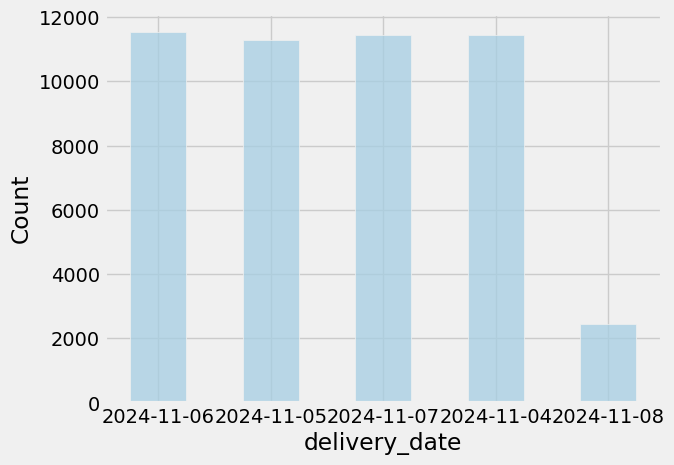

In [231]:
sns.histplot(data=contr_camp.query('channel == "sms" & t_flag == 1'),
             x='delivery_date',
             shrink=0.5)
# видно, что кол-во коммуникаций резко просело 8 ноября - возможно ошибка в системе рассылки - не будем учитывать этот вид коммуникации в анализе

<Axes: xlabel='delivery_date', ylabel='Count'>

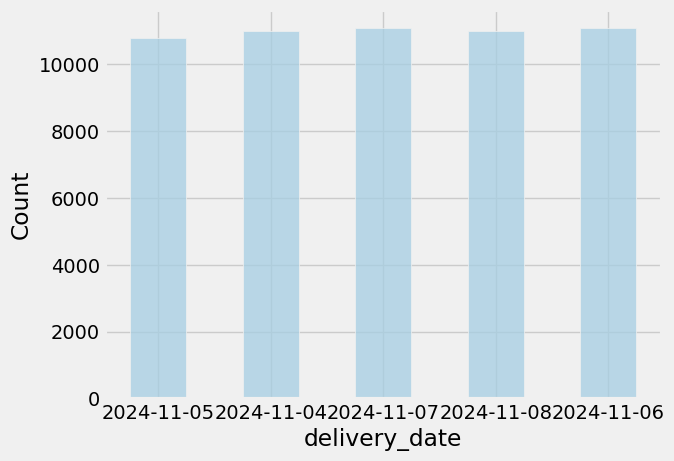

In [232]:
sns.histplot(data=contr_camp.query('channel == "banner" & t_flag == 1'),
             x='delivery_date',
             shrink=0.5)

<Axes: xlabel='delivery_date', ylabel='Count'>

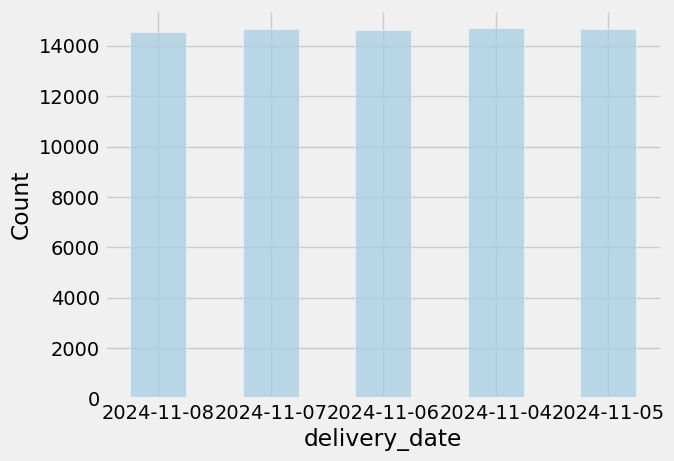

In [233]:
sns.histplot(data=contr_camp.query('channel == "push" & t_flag == 1'),
             x='delivery_date',
             shrink=0.5)

<Axes: xlabel='delivery_date', ylabel='Count'>

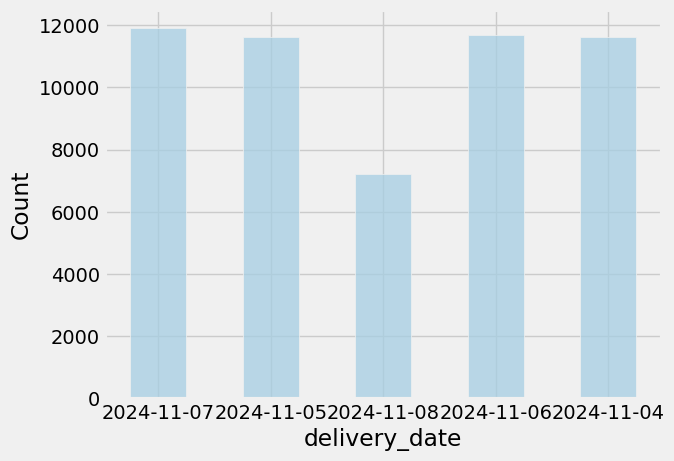

In [234]:
sns.histplot(data=contr_camp.query('channel == "other_ads" & t_flag == 1'),
             x='delivery_date',
             shrink=0.5)

### ваши выводы здесь

1) Обнаружена сломанная коммуникация SMS (таргет по наличию коммуникации и ее виду распределен равномерно, кроме SMS, и в один день что-то сломалась и кол-во кммуникаций было значительно меньше ожидаемого) - принято решение ее не рассматривать
2) Кол-во людей, получивших коммуникацию, равномерно распределено между способами коммуникации

<h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

Мы располагаем информацией за ноябрь, получается по пользователям нужно взять агрегаты до октября (report_dt ~ 2024-10-10)

### 2.1 Определение нужного периода агрегатов

In [235]:
features.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city
0,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,2025-01-31,1066338,26,Ufa
1,2.583579,1.755569,3.360186,-1.122864,0.034201,-0.269607,-1.503646,1.040289,-1.691606,2024-11-30,13900,35,Ufa
2,0.296030,-0.937075,1.073280,1.874636,-0.981216,-1.100187,-0.331181,-1.575637,0.474965,2025-03-31,4063636,28,Ufa
3,2.329328,-1.345159,0.345066,0.755373,-0.082842,0.028439,0.919211,0.808793,-0.560004,2025-03-31,1025488,27,Moscow
4,0.167643,1.587099,0.165357,0.289758,-1.108840,-1.501819,0.615588,1.631203,-0.208419,2025-02-28,4040555,37,Moscow


In [236]:
features.query('report_dt < "2024-10-15"')['report_dt'].describe()

count                 460000
mean     2024-09-30 00:00:00
min      2024-09-30 00:00:00
25%      2024-09-30 00:00:00
50%      2024-09-30 00:00:00
75%      2024-09-30 00:00:00
max      2024-09-30 00:00:00
Name: report_dt, dtype: object

Получается нам нужен report_dt = 2024-09-30

In [237]:
# фичи за правильный период
features_report = features.query('report_dt < "2024-10-15"')

### 2.2 Merge фичей к основному дф

In [238]:
full_data = contr_camp.query('channel != "sms"')\
                      .merge(features_report,
                             on='user_id',
                             how='left')\

full_data

,user_id,contract_date,contract_id,t_flag,delivery_date,all_dates,channel,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,age,city
0,1162,2024-11-13,0001_2024-11-13_1162,1,2024-11-08,2024-11-08,push,1,-1.224545,1.688111,0.150933,3.230149,-0.189105,0.551481,-1.229590,1.159411,-0.085720,2024-09-30,39,Moscow
1,42991,NaT,NaN,1,2024-11-07,2024-11-07,push,0,-0.916137,1.368764,1.841319,-1.529691,-0.608003,-1.116932,1.178124,-0.884607,-1.726070,2024-09-30,43,Moscow
2,24623,NaT,NaN,0,unknown,1990-01-01,push,0,2.281651,-0.354332,1.288191,-2.754188,0.202581,0.831745,-0.002779,-1.463527,1.976755,2024-09-30,39,Ufa
3,4001330,NaT,NaN,0,unknown,1990-01-01,banner,0,-1.821441,-0.847392,1.020568,-1.611153,0.933913,0.236984,0.933495,0.795683,-0.812175,2024-09-30,30,Smolensk
4,2101471,2024-11-11,0001_2024-11-11_2101471,0,unknown,2024-11-01,other_ads,1,2.365226,-1.303713,0.133301,2.098386,-0.000000,0.285846,0.545567,0.293677,-0.312559,2024-09-30,36,Ufa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382097,98949,NaT,NaN,0,unknown,1990-01-01,push,0,0.899306,2.466164,2.539867,-1.295733,3.118252,0.141617,2.900565,-0.369657,-1.519390,2024-09-30,24,Smolensk
382098,4108275,2024-11-15,0001_2024-11-15_4108275,1,2024-11-04,2024-11-04,banner,1,0.527103,-0.466468,2.738080,1.613084,-1.171931,0.311911,-0.932750,-0.751979,-0.503718,2024-09-30,36,Ufa
382099,131927,2024-11-27,0001_2024-11-27_131927,1,2024-11-06,2024-11-06,push,0,2.521111,-1.893176,2.540412,-1.912528,1.392247,-0.653322,0.541760,-1.209625,1.752634,2024-09-30,42,Ufa
382100,73995,NaT,NaN,0,unknown,1990-01-01,push,0,0.665340,1.771079,-0.323533,-1.224266,0.252920,-0.745952,-0.472200,0.879810,0.949838,2024-09-30,29,Smolensk


Теперь все данные объединены

### 2.3 UpLift EDA

#### 2.3.1 Однородность целевой и контрольной группы 

In [239]:
# фичи пользовтеля
feat_columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']

In [240]:
full_data.groupby('t_flag').agg({'target': 'mean'})
# значения сильно разнятся, но это бывает и допустимо

,target
t_flag,
0,0.321300
1,0.661525


In [241]:
full_data.groupby('t_flag')\
         .agg({'x1': 'mean',
               'x2': 'mean',
               'x3': 'mean',
               'x4': 'mean',
               'x5': 'mean',
               'x6': 'mean',
               'x7': 'mean',
               'x8': 'mean',
               'x9': 'mean',})

,x1,x2,x3,x4,x5,x6,x7,x8,x9
t_flag,,,,,,,,,
0,0.121318,-0.206758,0.513065,-0.363408,0.238925,-0.001426,0.200459,0.200184,0.070822
1,0.160762,-0.193008,0.472844,-0.295348,0.224227,0.000172,0.121881,0.193916,0.124018


In [242]:
full_data.groupby('t_flag')\
         .agg({'x1': 'median',
               'x2': 'median',
               'x3': 'median',
               'x4': 'median',
               'x5': 'median',
               'x6': 'median',
               'x7': 'median',
               'x8': 'median',
               'x9': 'median',})

,x1,x2,x3,x4,x5,x6,x7,x8,x9
t_flag,,,,,,,,,
0,0.291126,-0.196562,0.544125,-0.403500,-0.000000,0.001176,0.295634,0.439515,-0.030885
1,0.329990,-0.180249,0.511346,-0.318433,0.216078,0.003046,0.129393,0.404864,0.035605


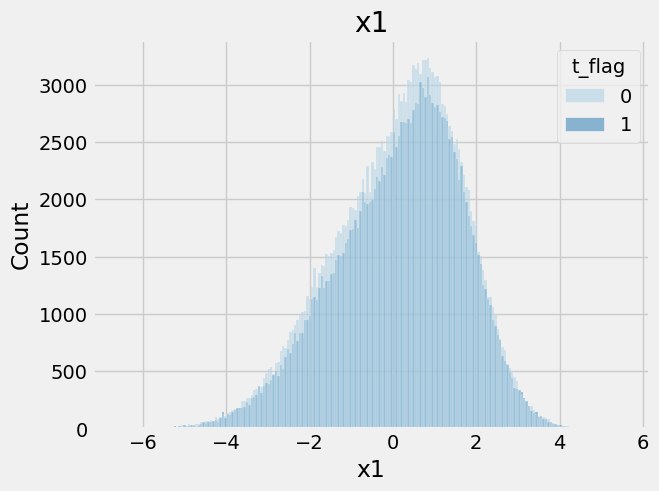

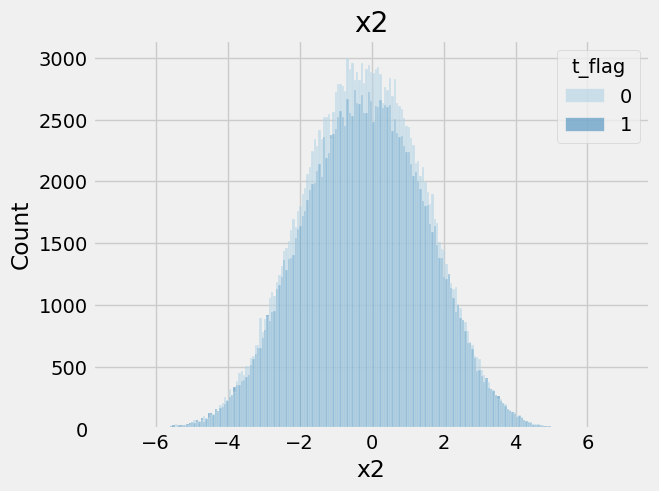

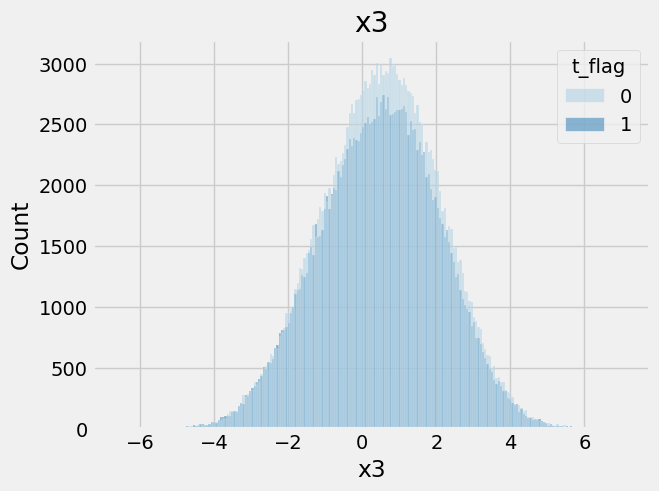

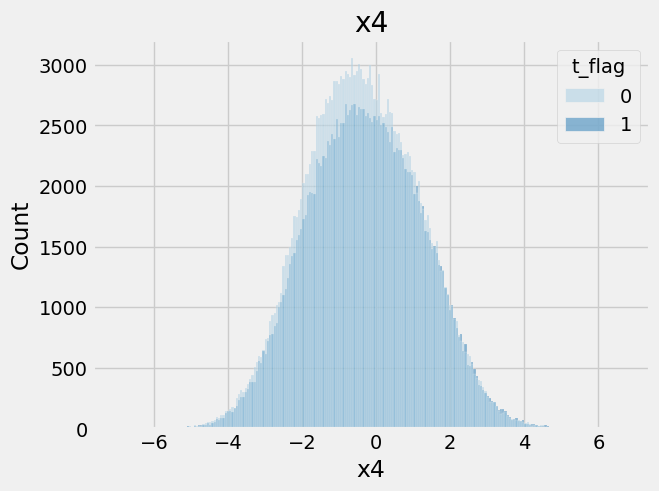

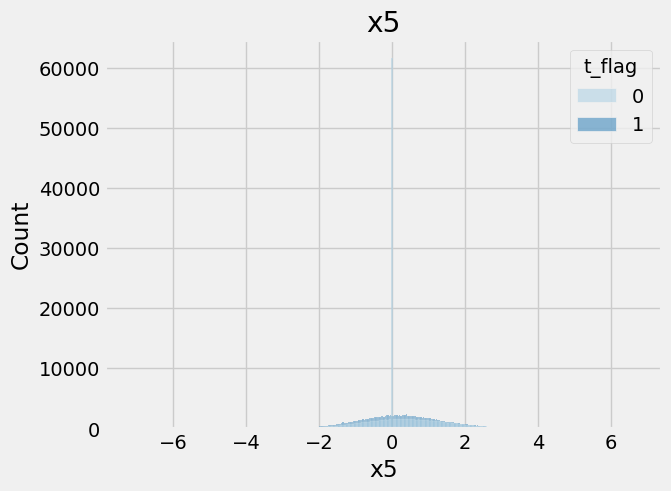

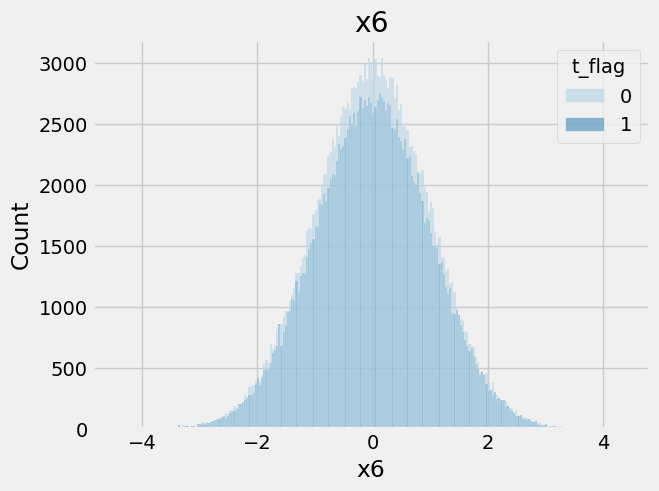

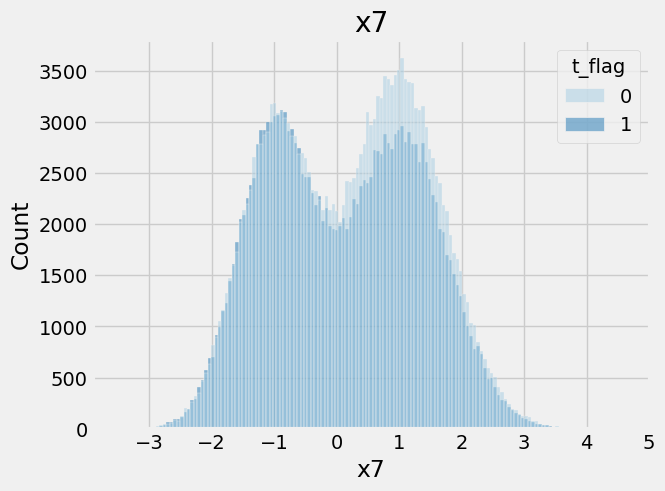

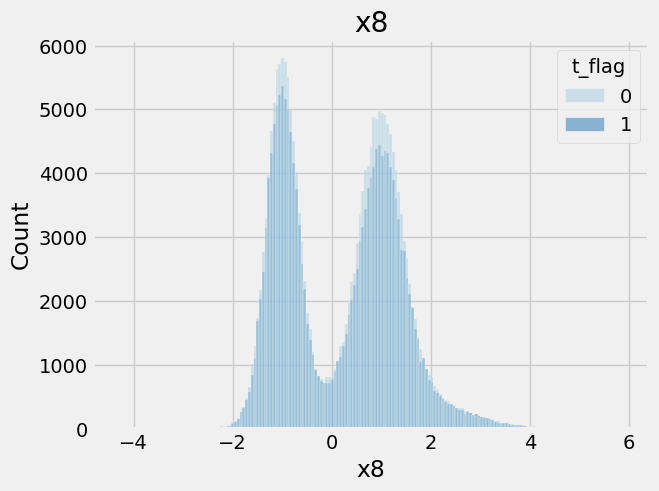

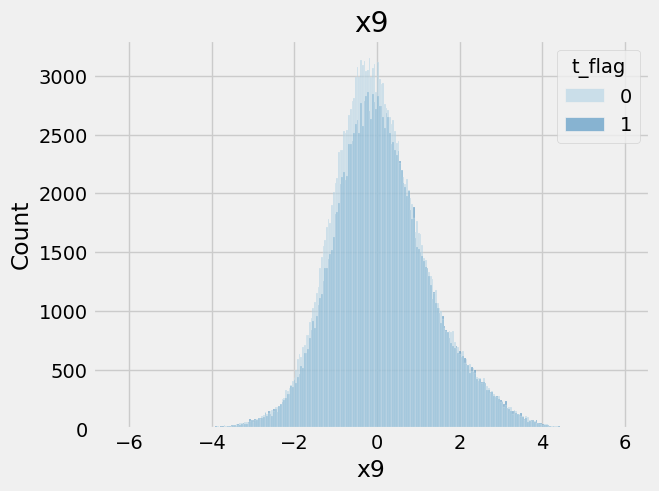

In [243]:
for col in feat_columns:
    sns.histplot(data = full_data, x=col, hue='t_flag').set_title(col)
    plt.show()

Распределения в целом совпадают, но есть аномальное количество нулевых значений фичи **x5**

In [244]:
full_data.query('x5 == 0')

,user_id,contract_date,contract_id,t_flag,delivery_date,all_dates,channel,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,age,city
4,2101471,2024-11-11,0001_2024-11-11_2101471,0,unknown,2024-11-01,other_ads,1,2.365226,-1.303713,0.133301,2.098386,-0.0,0.285846,0.545567,0.293677,-0.312559,2024-09-30,36,Ufa
5,2086041,NaT,NaN,0,unknown,1990-01-01,other_ads,0,-1.691378,-2.037854,0.720855,0.078692,0.0,0.200561,-0.473317,-1.199639,-0.021610,2024-09-30,29,Smolensk
7,2009627,2024-11-12,0001_2024-11-12_2009627,0,unknown,2024-11-01,other_ads,1,0.719305,-3.875339,-2.520893,1.791964,0.0,-0.349731,0.770023,0.550603,0.507014,2024-09-30,33,Smolensk
13,2084899,2024-11-13,0001_2024-11-13_2084899,0,unknown,2024-11-01,other_ads,1,0.323891,-0.754499,-1.115373,0.468133,0.0,-0.888773,2.875067,1.600777,-1.010896,2024-09-30,38,Ufa
21,2039414,NaT,NaN,0,unknown,1990-01-01,other_ads,0,-0.543462,0.517882,2.745671,0.411318,0.0,0.812803,-1.158283,-0.989393,-0.396452,2024-09-30,37,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382061,2036525,NaT,NaN,0,unknown,1990-01-01,other_ads,0,-3.187885,1.204662,3.181823,-0.948509,-0.0,0.580416,-0.968236,-0.574454,-0.641733,2024-09-30,39,Ufa
382076,2071855,NaT,NaN,0,unknown,1990-01-01,other_ads,0,-2.632954,-1.845796,0.364818,0.024840,0.0,0.439699,-0.784093,-1.131720,0.254472,2024-09-30,34,Smolensk
382077,2060577,2024-11-04,0001_2024-11-04_2060577,0,unknown,2024-11-01,other_ads,1,1.347945,-1.183887,-0.811179,0.449185,0.0,0.864381,1.436114,1.243330,-0.416034,2024-09-30,35,Smolensk
382084,2113479,NaT,NaN,0,unknown,1990-01-01,other_ads,0,0.192611,-2.539540,-0.278562,-0.491431,0.0,-0.161891,1.028837,1.110961,-0.403948,2024-09-30,21,Smolensk


In [245]:
full_data['t_flag'].value_counts()

t_flag
0    200000
1    182102
Name: count, dtype: int64

In [246]:
full_data.groupby('channel').agg({'x5': 'median'})

,x5
channel,
banner,-0.000056
other_ads,0.000000
push,0.704064


### ваши выводы здесь

1) Распределения в целом совпадают, признак X5 содержит аномальные значения, поэтому он был исключен из дальнейшего анализа

<h2> 3. Построение моделей и оценка их качества (14 баллов)</h2>

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

### 3.1 Подготовка

In [ ]:
from sklearn.model_selection import train_test_split

In [248]:
full_data.head()

,user_id,contract_date,contract_id,t_flag,delivery_date,all_dates,channel,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,age,city
0,1162,2024-11-13,0001_2024-11-13_1162,1,2024-11-08,2024-11-08,push,1,-1.224545,1.688111,0.150933,3.230149,-0.189105,0.551481,-1.229590,1.159411,-0.085720,2024-09-30,39,Moscow
1,42991,NaT,NaN,1,2024-11-07,2024-11-07,push,0,-0.916137,1.368764,1.841319,-1.529691,-0.608003,-1.116932,1.178124,-0.884607,-1.726070,2024-09-30,43,Moscow
2,24623,NaT,NaN,0,unknown,1990-01-01,push,0,2.281651,-0.354332,1.288191,-2.754188,0.202581,0.831745,-0.002779,-1.463527,1.976755,2024-09-30,39,Ufa
3,4001330,NaT,NaN,0,unknown,1990-01-01,banner,0,-1.821441,-0.847392,1.020568,-1.611153,0.933913,0.236984,0.933495,0.795683,-0.812175,2024-09-30,30,Smolensk
4,2101471,2024-11-11,0001_2024-11-11_2101471,0,unknown,2024-11-01,other_ads,1,2.365226,-1.303713,0.133301,2.098386,-0.000000,0.285846,0.545567,0.293677,-0.312559,2024-09-30,36,Ufa


Выделим дф с признаками пользователя, таргетом и флагом коммуникации

In [249]:
# исключим аномальный признак x5
model_df = full_data[['x1', 'x2', 'x3', 'x4', 'x6', 'x7', 'x8', 'x9', 'age', 'city', 't_flag', 'channel', 'target']]
model_df

,x1,x2,x3,x4,x6,x7,x8,x9,age,city,t_flag,channel,target
0,-1.224545,1.688111,0.150933,3.230149,0.551481,-1.229590,1.159411,-0.085720,39,Moscow,1,push,1
1,-0.916137,1.368764,1.841319,-1.529691,-1.116932,1.178124,-0.884607,-1.726070,43,Moscow,1,push,0
2,2.281651,-0.354332,1.288191,-2.754188,0.831745,-0.002779,-1.463527,1.976755,39,Ufa,0,push,0
3,-1.821441,-0.847392,1.020568,-1.611153,0.236984,0.933495,0.795683,-0.812175,30,Smolensk,0,banner,0
4,2.365226,-1.303713,0.133301,2.098386,0.285846,0.545567,0.293677,-0.312559,36,Ufa,0,other_ads,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
382097,0.899306,2.466164,2.539867,-1.295733,0.141617,2.900565,-0.369657,-1.519390,24,Smolensk,0,push,0
382098,0.527103,-0.466468,2.738080,1.613084,0.311911,-0.932750,-0.751979,-0.503718,36,Ufa,1,banner,1
382099,2.521111,-1.893176,2.540412,-1.912528,-0.653322,0.541760,-1.209625,1.752634,42,Ufa,1,push,0
382100,0.665340,1.771079,-0.323533,-1.224266,-0.745952,-0.472200,0.879810,0.949838,29,Smolensk,0,push,0


Применим OHE для кодирования города

In [ ]:
# One-Hot Encoding для столбца 'category'
one_hot = pd.get_dummies(model_df['city'], prefix='city')

# Удаление одного из столбцов
one_hot = one_hot.drop(one_hot.columns[0], axis=1)

# Присоединение результата к исходному DataFrame
df = pd.concat([model_df, one_hot], axis=1)

df.drop(columns=['city'], inplace=True)

In [251]:
df.head()

,x1,x2,x3,x4,x6,x7,x8,x9,age,t_flag,channel,target,city_Smolensk,city_Ufa
0,-1.224545,1.688111,0.150933,3.230149,0.551481,-1.229590,1.159411,-0.085720,39,1,push,1,False,False
1,-0.916137,1.368764,1.841319,-1.529691,-1.116932,1.178124,-0.884607,-1.726070,43,1,push,0,False,False
2,2.281651,-0.354332,1.288191,-2.754188,0.831745,-0.002779,-1.463527,1.976755,39,0,push,0,False,True
3,-1.821441,-0.847392,1.020568,-1.611153,0.236984,0.933495,0.795683,-0.812175,30,0,banner,0,True,False
4,2.365226,-1.303713,0.133301,2.098386,0.285846,0.545567,0.293677,-0.312559,36,0,other_ads,1,False,True


In [ ]:
# Другой порядок столбцов
columns_to_move = ['t_flag', 'target']

new_columns_order = [col for col in df.columns if col not in columns_to_move] + columns_to_move
df = df[new_columns_order]

In [253]:
df.head()

,x1,x2,x3,x4,x6,x7,x8,x9,age,channel,city_Smolensk,city_Ufa,t_flag,target
0,-1.224545,1.688111,0.150933,3.230149,0.551481,-1.229590,1.159411,-0.085720,39,push,False,False,1,1
1,-0.916137,1.368764,1.841319,-1.529691,-1.116932,1.178124,-0.884607,-1.726070,43,push,False,False,1,0
2,2.281651,-0.354332,1.288191,-2.754188,0.831745,-0.002779,-1.463527,1.976755,39,push,False,True,0,0
3,-1.821441,-0.847392,1.020568,-1.611153,0.236984,0.933495,0.795683,-0.812175,30,banner,True,False,0,0
4,2.365226,-1.303713,0.133301,2.098386,0.285846,0.545567,0.293677,-0.312559,36,other_ads,False,True,0,1


In [254]:
model_df_ohe = df.copy()

Выделим отдельные датафреймы для каждого вида коммуникации

In [255]:
model_df_banner = model_df_ohe.query('channel == "banner"').drop(columns=['channel'])
model_df_other_ads = model_df_ohe.query('channel == "other_ads"').drop(columns=['channel'])
model_df_push = model_df_ohe.query('channel == "push"').drop(columns=['channel'])

In [256]:
model_df_banner

,x1,x2,x3,x4,x6,x7,x8,x9,age,city_Smolensk,city_Ufa,t_flag,target
3,-1.821441,-0.847392,1.020568,-1.611153,0.236984,0.933495,0.795683,-0.812175,30,True,False,0,0
8,1.835344,1.073112,-0.629534,0.885258,1.253187,-1.129575,-0.397609,0.770880,36,False,True,0,1
11,-2.560545,-1.059789,1.364528,0.162776,-0.674086,1.523135,1.669412,-1.219946,20,False,False,1,0
16,-2.473590,0.538802,2.107212,-2.082812,-0.820763,0.955939,0.626842,-1.203440,31,True,False,0,0
29,-0.917875,-1.830777,-0.489967,-2.968060,0.060708,-1.220622,-1.031396,0.766407,21,False,True,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
382083,0.601431,-1.721380,0.030688,1.082877,-0.531213,-0.845166,-1.068111,0.401184,22,True,False,1,1
382085,-1.241470,0.032272,2.000194,-0.785107,0.488036,-0.085472,0.705049,-0.658411,33,False,False,1,0
382091,-1.742837,-0.090977,1.400905,-1.788029,1.259562,-0.807524,-1.215689,-0.096739,20,False,False,0,0
382096,-0.582920,-1.698049,1.183558,0.104737,2.387585,0.515051,0.816445,-0.665276,36,False,True,1,0


Разделим выборки для каждой коммуникации

In [257]:
# индексы
banner_train_index, banner_test_index = train_test_split(model_df_banner.index, test_size=0.25, random_state=42)
other_train_index, other_test_index = train_test_split(model_df_other_ads.index, test_size=0.25, random_state=42)
push_train_index, push_test_index = train_test_split(model_df_push.index, test_size=0.25, random_state=42)

In [258]:
# train и тест датафреймы
train_banner_df = model_df_banner.loc[banner_train_index].copy()
train_other_df = model_df_other_ads.loc[other_train_index].copy()
train_push_df = model_df_push.loc[push_train_index].copy()

test_banner_df = model_df_banner.loc[banner_test_index].copy()
test_other_df = model_df_other_ads.loc[other_test_index].copy()
test_push_df = model_df_push.loc[push_test_index].copy()

In [259]:
# Разбиение на X и y train и test

# train
X_train_banner_df = train_banner_df.drop(columns=['target'])
y_train_banner_df = train_banner_df['target']

X_train_other_df = train_other_df.drop(columns=['target'])
y_train_other_df = train_other_df['target']

X_train_push_df = train_push_df.drop(columns=['target'])
y_train_push_df = train_push_df['target']

# test
X_test_banner_df = test_banner_df.drop(columns=['target'])
y_test_banner_df = test_banner_df['target']

X_test_other_df = test_other_df.drop(columns=['target'])
y_test_other_df = test_other_df['target']

X_test_push_df = test_push_df.drop(columns=['target'])
y_test_push_df = test_push_df['target']

### 3.2 SoloModel руками

In [260]:
from sklearn.linear_model import LogisticRegression

LogisticRegression для всех коммуникаций

In [261]:
model_logreg_banner = LogisticRegression(random_state=42)
model_logreg_other = LogisticRegression(random_state=42)
model_logreg_push = LogisticRegression(random_state=42)
model_logreg_pipe = LogisticRegression(random_state=42)

In [262]:
model_logreg_banner.fit(X_train_banner_df, y_train_banner_df)
model_logreg_other.fit(X_train_other_df, y_train_other_df)
model_logreg_push.fit(X_train_push_df, y_train_push_df)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

LogisticRegression(random_state=42)

Создание фиктивного столбца группы пользователя

In [263]:
# banner
X_test_banner_df_0 = X_test_banner_df.copy()
X_test_banner_df_0['t_flag'] = 0

X_test_banner_df_1 = X_test_banner_df.copy()
X_test_banner_df_1['t_flag'] = 1

# other
X_test_other_df_0 = X_test_other_df.copy()
X_test_other_df_0['t_flag'] = 0

X_test_other_df_1 = X_test_other_df.copy()
X_test_other_df_1['t_flag'] = 1

# push
X_test_push_df_0 = X_test_push_df.copy()
X_test_push_df_0['t_flag'] = 0

X_test_push_df_1 = X_test_push_df.copy()
X_test_push_df_1['t_flag'] = 1

X_test_push_df_1.head()

,x1,x2,x3,x4,x6,x7,x8,x9,age,city_Smolensk,city_Ufa,t_flag
184783,0.146422,1.561102,0.858586,0.134239,1.462556,0.132374,2.560084,0.021856,38,True,False,1
355723,0.265870,3.448989,1.401752,-1.567298,-0.939084,-0.627939,2.433236,0.727501,25,False,False,1
347904,2.553067,-1.766784,0.874272,-2.589677,-0.793506,-0.730146,3.627722,2.787817,39,False,False,1
4795,0.415864,0.432791,1.207979,-2.563094,-1.399266,2.810624,-0.399580,-1.866518,37,False,True,1
260415,1.579520,0.741498,0.767600,-0.021730,-2.110150,-0.321050,0.799769,1.621242,36,False,False,1


Предсказание

In [264]:
# banner
y_pred_banner_0 = model_logreg_banner.predict_proba(X_test_banner_df_0)[:,1]
y_pred_banner_1 = model_logreg_banner.predict_proba(X_test_banner_df_1)[:,1]

# other 
y_pred_other_0 = model_logreg_other.predict_proba(X_test_other_df_0)[:,1]
y_pred_other_1 = model_logreg_other.predict_proba(X_test_other_df_1)[:,1]

# push
y_pred_push_0 = model_logreg_push.predict_proba(X_test_push_df_0)[:,1]
y_pred_push_1 = model_logreg_push.predict_proba(X_test_push_df_1)[:,1]

Вычисляем UpLift

In [265]:
uplift_banner = y_pred_banner_1 - y_pred_banner_0
uplift_other = y_pred_other_1 - y_pred_other_0
uplift_push = y_pred_push_1 - y_pred_push_0

Визуал

In [266]:
# дф uplift для баннера
uplift_banner_df = pd.DataFrame(data = uplift_banner, index = X_test_banner_df.index, columns=['uplift'])
uplift_banner_df = uplift_banner_df.sort_values(by='uplift', ascending=False)

# дф uplift для other
uplift_other_df = pd.DataFrame(data = uplift_other, index = X_test_other_df.index, columns=['uplift'])
uplift_other_df = uplift_other_df.sort_values(by='uplift', ascending=False)

# дф uplift для push
uplift_push_df = pd.DataFrame(data = uplift_push, index = X_test_push_df.index, columns=['uplift'])
uplift_push_df = uplift_push_df.sort_values(by='uplift', ascending=False)


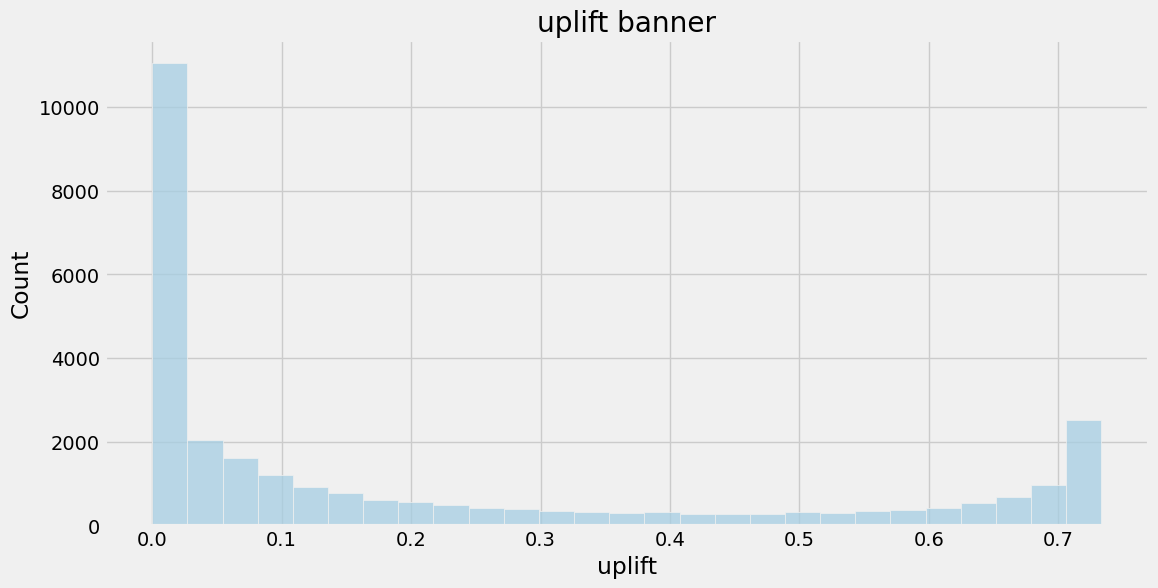

In [267]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data = uplift_banner_df, x='uplift').set_title('uplift banner')
plt.show()

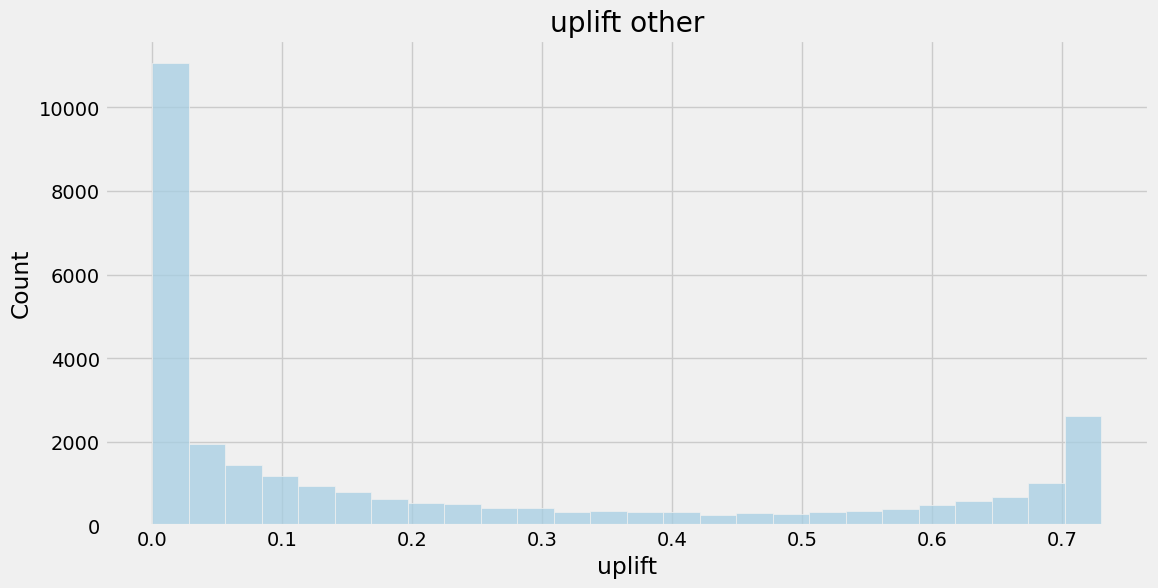

In [268]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data = uplift_other_df, x='uplift').set_title('uplift other')
plt.show()

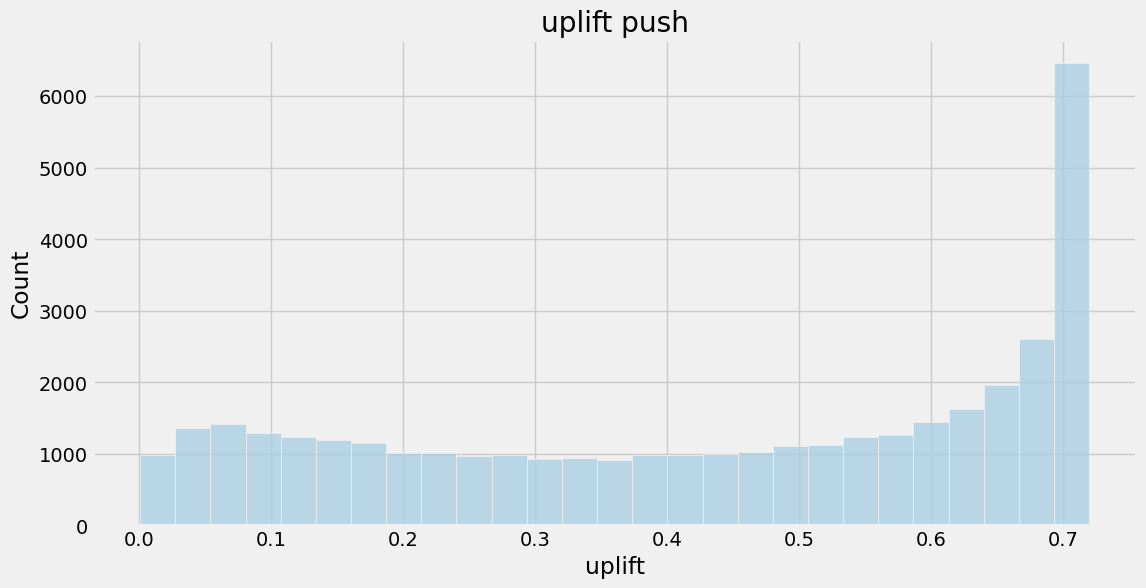

In [269]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data = uplift_push_df, x='uplift').set_title('uplift push')
plt.show()

In [271]:
from sklearn.utils._optional_dependencies import (check_matplotlib_support,
                                                  check_pandas_support)
import sklearn.utils
sklearn.utils.check_matplotlib_support = check_matplotlib_support

In [272]:
from sklift.models import (SoloModel,
                           TwoModels,
                           ClassTransformation,
                           ClassTransformationReg)
from sklift.metrics import (uplift_at_k,
                            uplift_auc_score,
                            qini_auc_score,
                            make_uplift_scorer)
from sklift.viz import plot_qini_curve, plot_uplift_curve

In [273]:
# баннеры
qini_auc_score(y_true=y_test_banner_df,
               uplift=pd.Series(uplift_banner, index=X_test_banner_df.index),
               treatment=X_test_banner_df['t_flag'])

0.1840217953930534

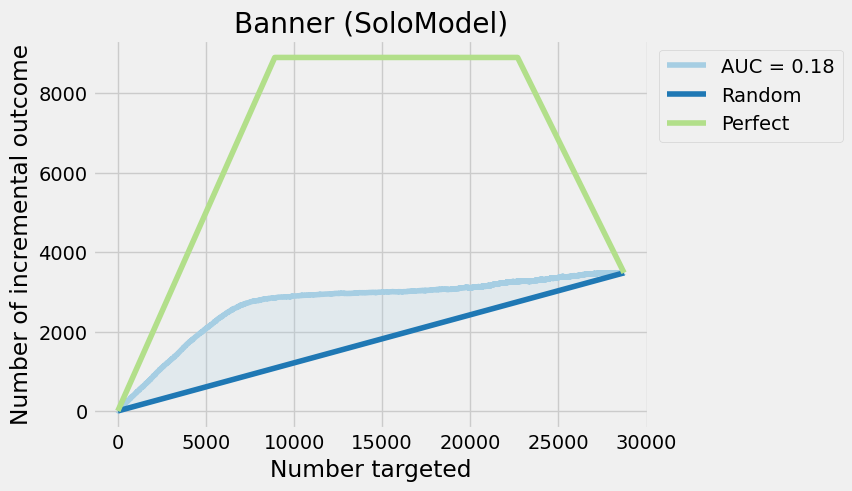

In [274]:
# баннеры
plot_qini_curve(y_true=y_test_banner_df,
                  uplift=pd.Series(uplift_banner, index=X_test_banner_df.index),
                  treatment=X_test_banner_df['t_flag'])
plt.title('Banner (SoloModel)')
plt.show()

In [275]:
# other
qini_auc_score(y_true=y_test_other_df,
               uplift=pd.Series(uplift_other, index=X_test_other_df.index),
               treatment=X_test_other_df['t_flag'])

0.19022002176090388

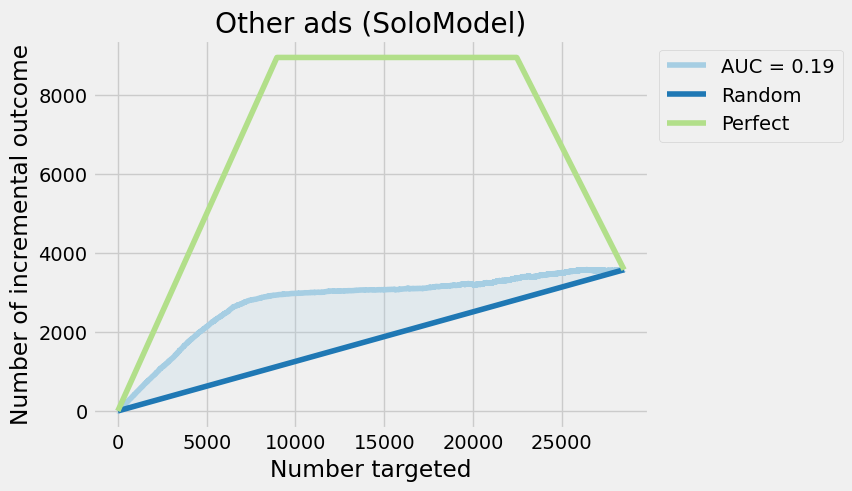

In [276]:
# other
plot_qini_curve(y_true=y_test_other_df,
                  uplift=pd.Series(uplift_other, index=X_test_other_df.index),
                  treatment=X_test_other_df['t_flag'])
plt.title('Other ads (SoloModel)')
plt.show()

In [277]:
# push
qini_auc_score(y_true=y_test_push_df,
               uplift=pd.Series(uplift_push, index=X_test_push_df.index),
               treatment=X_test_push_df['t_flag'])

0.191902488140013

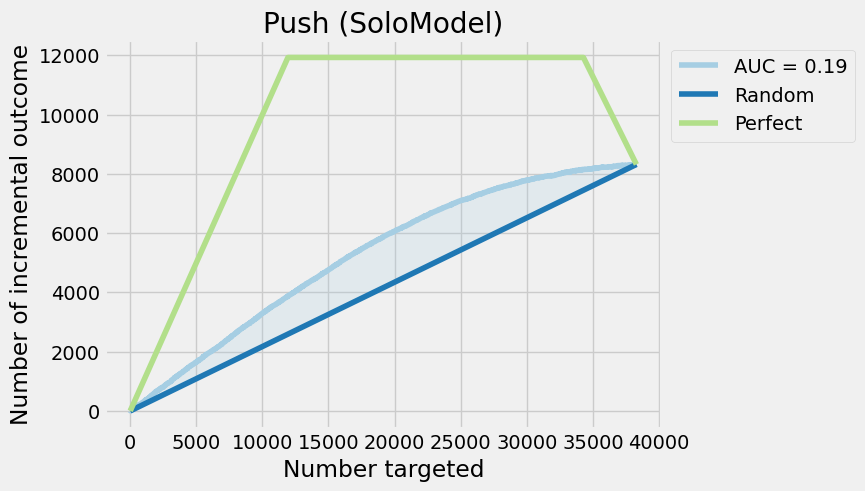

In [278]:
# push
plot_qini_curve(y_true=y_test_push_df,
                  uplift=pd.Series(uplift_push, index=X_test_push_df.index),
                  treatment=X_test_push_df['t_flag'])
plt.title('Push (SoloModel)')
plt.show()

### 3.3 SoloModel Sklift

In [279]:
sm_banner = SoloModel(estimator=model_logreg_banner)
sm_other = SoloModel(estimator=model_logreg_other)
sm_push = SoloModel(estimator=model_logreg_push)

sm_pipe = SoloModel(estimator=model_logreg_pipe)

In [280]:
sm_banner.fit(X_train_banner_df.drop(columns='t_flag'),
              y_train_banner_df,
              treatment=X_train_banner_df['t_flag'])

sm_other.fit(X_train_other_df.drop(columns='t_flag'),
              y_train_other_df,
              treatment=X_train_other_df['t_flag'])

sm_push.fit(X_train_push_df.drop(columns='t_flag'),
              y_train_push_df,
              treatment=X_train_push_df['t_flag'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

SoloModel(estimator=LogisticRegression(random_state=42))

In [281]:
uplift_banner_sklift = sm_banner.predict(X_test_banner_df.drop(columns='t_flag'))
uplift_other_sklift = sm_other.predict(X_test_other_df.drop(columns='t_flag'))
uplift_push_sklift = sm_push.predict(X_test_push_df.drop(columns='t_flag'))

Pipelines

In [282]:
from sklearn.pipeline import Pipeline

In [283]:
uplift_sklift_pipe = Pipeline(steps=[
    ('model_uplift', sm_pipe)
])

In [284]:
uplift_sklift_pipe.fit(X_train_banner_df.drop(columns='t_flag'),
         y_train_banner_df,
         model_uplift__treatment=X_train_banner_df['t_flag'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('model_uplift',
                 SoloModel(estimator=LogisticRegression(random_state=42)))])

In [285]:
uplift_pipe = uplift_sklift_pipe.predict(X_test_banner_df.drop(columns='t_flag'))

Визуал

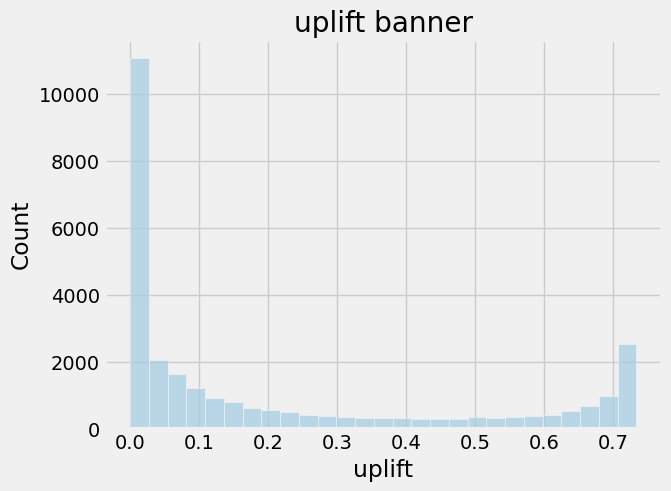

In [286]:
uplift_pd = pd.DataFrame(data = uplift_banner_sklift, index = X_test_banner_df.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
sns.histplot(data = uplift_pd, x='uplift').set_title('uplift banner')
plt.show()

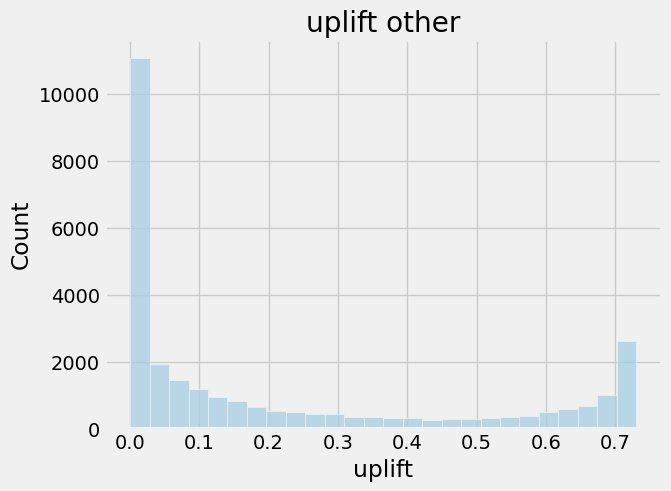

In [287]:
uplift_pd = pd.DataFrame(data = uplift_other_sklift, index = X_test_other_df.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
sns.histplot(data = uplift_pd, x='uplift').set_title('uplift other')
plt.show()

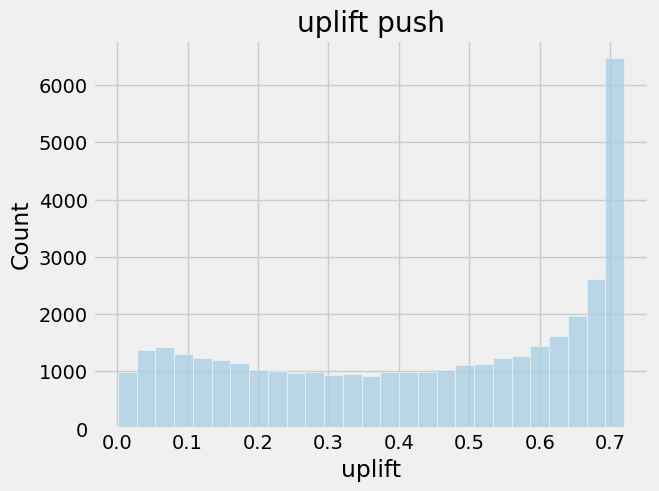

In [288]:
uplift_pd = pd.DataFrame(data = uplift_push_sklift, index = X_test_push_df.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
sns.histplot(data = uplift_pd, x='uplift').set_title('uplift push')
plt.show()

In [289]:
# баннеры
qini_auc_score(y_true=y_test_banner_df,
               uplift=pd.Series(uplift_banner_sklift, index=X_test_banner_df.index),
               treatment=X_test_banner_df['t_flag'])


0.1840217953930534

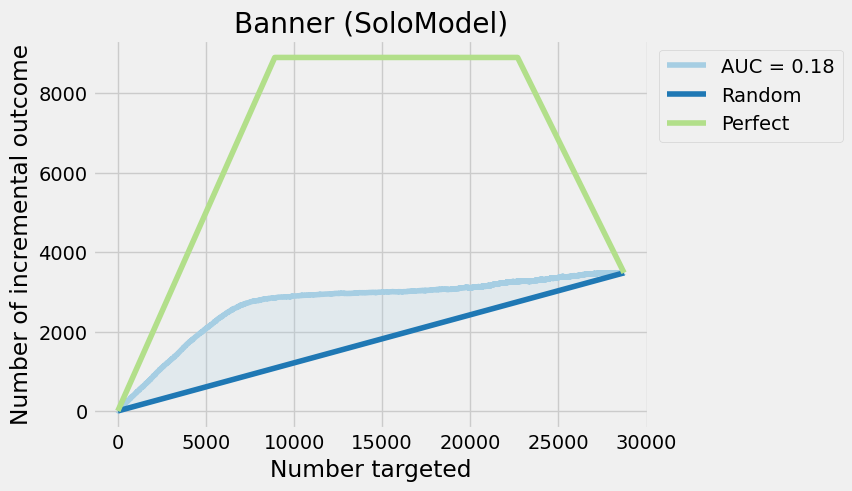

In [290]:
# баннеры
plot_qini_curve(y_true=y_test_banner_df,
                  uplift=pd.Series(uplift_banner_sklift, index=X_test_banner_df.index),
                  treatment=X_test_banner_df['t_flag'])
plt.title('Banner (SoloModel)')
plt.show()

In [291]:
# other
qini_auc_score(y_true=y_test_other_df,
               uplift=pd.Series(uplift_other_sklift, index=X_test_other_df.index),
               treatment=X_test_other_df['t_flag'])

0.19022002176090388

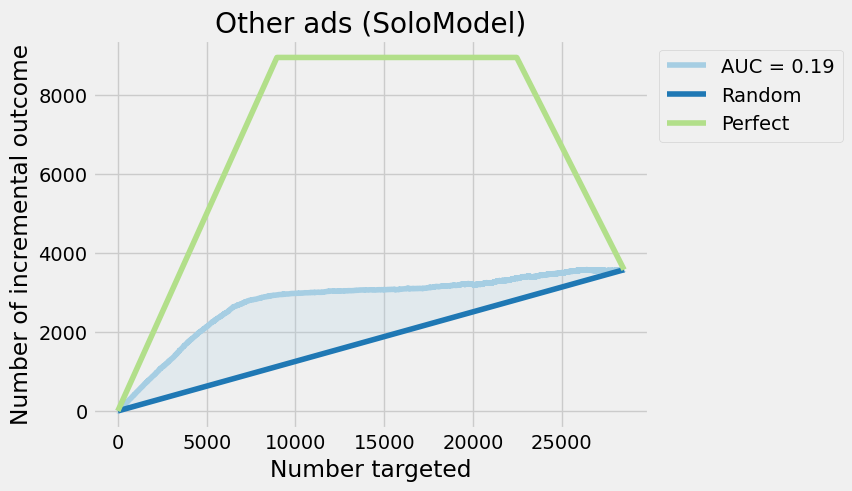

In [292]:
# other
plot_qini_curve(y_true=y_test_other_df,
                  uplift=pd.Series(uplift_other_sklift, index=X_test_other_df.index),
                  treatment=X_test_other_df['t_flag'])
plt.title('Other ads (SoloModel)')
plt.show()

In [293]:
# push
qini_auc_score(y_true=y_test_push_df,
               uplift=pd.Series(uplift_push_sklift, index=X_test_push_df.index),
               treatment=X_test_push_df['t_flag'])

0.191902488140013

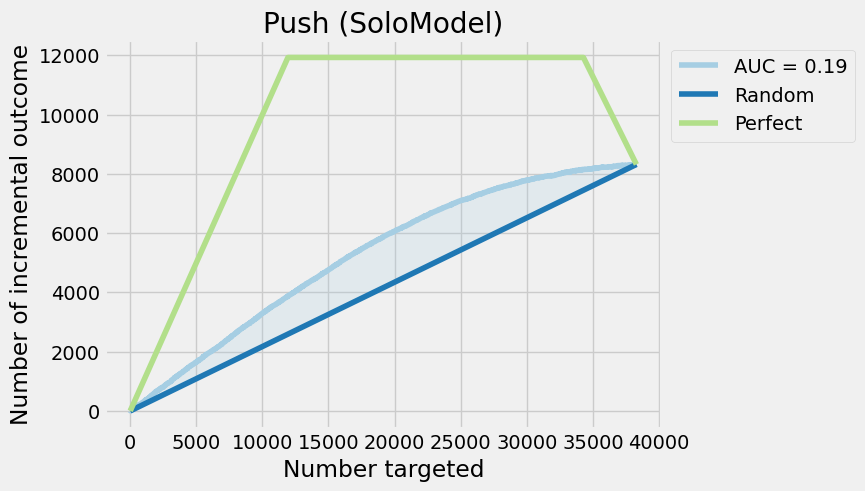

In [294]:
# push
plot_qini_curve(y_true=y_test_push_df,
                  uplift=pd.Series(uplift_push_sklift, index=X_test_push_df.index),
                  treatment=X_test_push_df['t_flag'])
plt.title('Push (SoloModel)')
plt.show()

### 3.4 Калибровка MetaLearner

In [295]:
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from catboost import CatBoostClassifier

In [296]:
skf = StratifiedKFold(n_splits=5,
                      random_state=42,
                      shuffle=True)

In [297]:
model_all_cb = CatBoostClassifier(verbose=0, random_seed=42, thread_count=7)
calib_model_all = CalibratedClassifierCV(estimator=model_all_cb, method='isotonic', cv=skf)

In [298]:
banner_catboost = SoloModel(estimator=calib_model_all)
other_catboost = SoloModel(estimator=calib_model_all)
push_catboost = SoloModel(estimator=calib_model_all)

In [299]:
banner_catboost.fit(X_train_banner_df.drop(columns='t_flag'),
                y_train_banner_df,
                treatment=X_train_banner_df['t_flag'])

other_catboost.fit(X_train_other_df.drop(columns='t_flag'),
                y_train_other_df,
                treatment=X_train_other_df['t_flag'])

push_catboost.fit(X_train_push_df.drop(columns='t_flag'),
                y_train_push_df,
                treatment=X_train_push_df['t_flag'])

SoloModel(estimator=CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                           estimator=<catboost.core.CatBoostClassifier object at 0x317e12f00>,
                                           method='isotonic'))

In [300]:
uplift_banner_cb = banner_catboost.predict(X_test_banner_df.drop(columns='t_flag'))
uplift_other_cb = other_catboost.predict(X_test_other_df.drop(columns='t_flag'))
uplift_push_cb = push_catboost.predict(X_test_push_df.drop(columns='t_flag'))

In [301]:
# баннеры
qini_auc_score(y_true=y_test_banner_df,
               uplift=pd.Series(uplift_banner_cb, index=X_test_banner_df.index),
               treatment=X_test_banner_df['t_flag'])

-0.06121042114114358

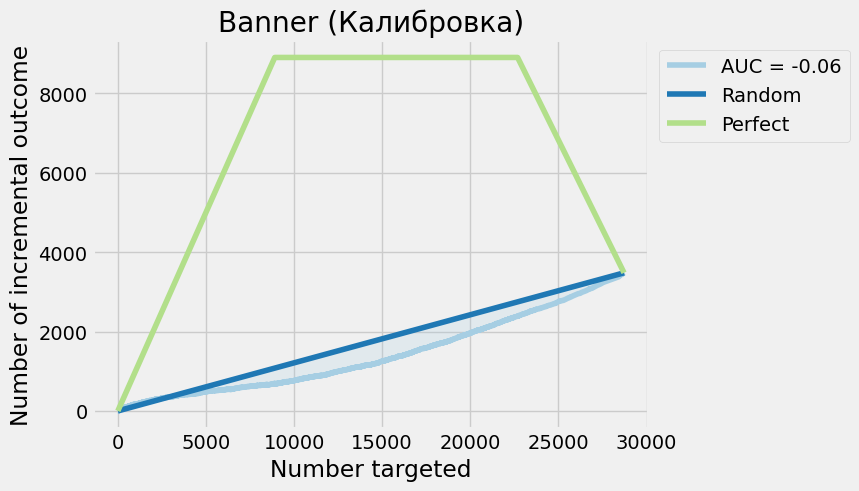

In [302]:
# баннеры
plot_qini_curve(y_true=y_test_banner_df,
                  uplift=pd.Series(uplift_banner_cb, index=X_test_banner_df.index),
                  treatment=X_test_banner_df['t_flag'])
plt.title('Banner (Калибровка)')
plt.show()

In [303]:
# other
qini_auc_score(y_true=y_test_other_df,
               uplift=pd.Series(uplift_other_cb, index=X_test_other_df.index),
               treatment=X_test_other_df['t_flag'])

-0.0634751412201039

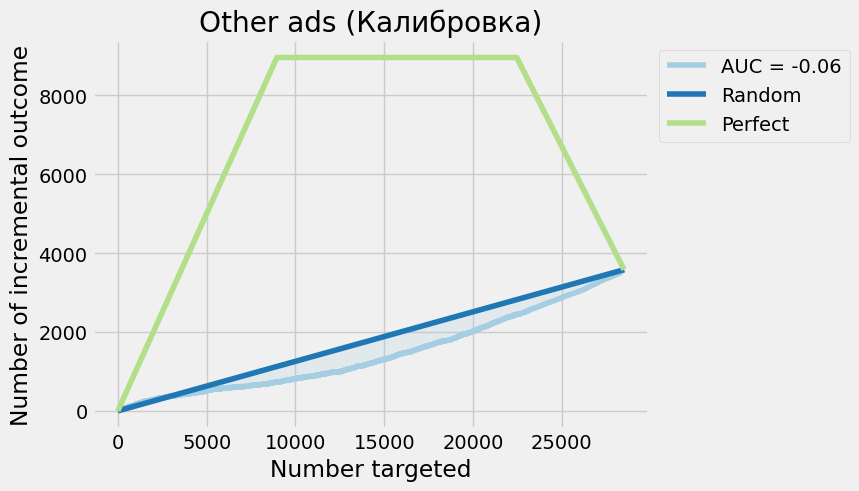

In [304]:
# other
plot_qini_curve(y_true=y_test_other_df,
                  uplift=pd.Series(uplift_other_cb, index=X_test_other_df.index),
                  treatment=X_test_other_df['t_flag'])
plt.title('Other ads (Калибровка)')
plt.show()

In [305]:
# push
qini_auc_score(y_true=y_test_push_df,
               uplift=pd.Series(uplift_push_cb, index=X_test_push_df.index),
               treatment=X_test_push_df['t_flag'])

0.3739970092726978

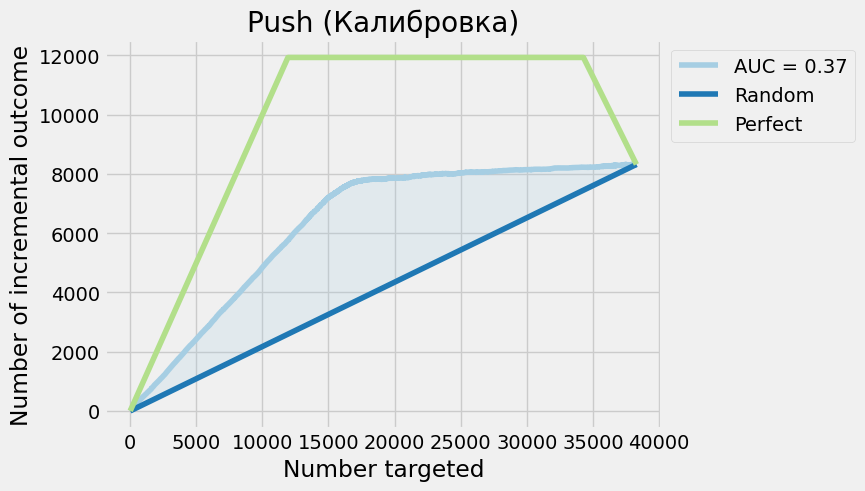

In [306]:
# push
plot_qini_curve(y_true=y_test_push_df,
                  uplift=pd.Series(uplift_push_cb, index=X_test_push_df.index),
                  treatment=X_test_push_df['t_flag'])
plt.title('Push (Калибровка)')
plt.show()

### 3.5 ClassTransformation

In [307]:
ct_banner = ClassTransformation(calib_model_all)
# fit the model
ct_banner = ct_banner.fit(X_train_banner_df.drop(columns='t_flag'),
                y_train_banner_df,
                treatment=X_train_banner_df['t_flag'])
# predict uplift
uplift_ct_banner = ct_banner.predict(X_test_banner_df.drop(columns='t_flag'))

In [308]:
ct_other = ClassTransformation(calib_model_all)
# fit the model
ct_other = ct_other.fit(X_train_other_df.drop(columns='t_flag'),
                y_train_other_df,
                treatment=X_train_other_df['t_flag'])
# predict uplift
uplift_ct_other = ct_other.predict(X_test_other_df.drop(columns='t_flag'))

In [309]:
ct_push = ClassTransformation(calib_model_all)
# fit the model
ct_push = ct_push.fit(X_train_push_df.drop(columns='t_flag'),
                y_train_push_df,
                treatment=X_train_push_df['t_flag'])
# predict uplift
uplift_ct_push = ct_push.predict(X_test_push_df.drop(columns='t_flag'))

In [310]:
# баннеры
qini_auc_score(y_true=y_test_banner_df,
               uplift=pd.Series(uplift_ct_banner, index=X_test_banner_df.index),
               treatment=X_test_banner_df['t_flag'])

0.20073245463660722

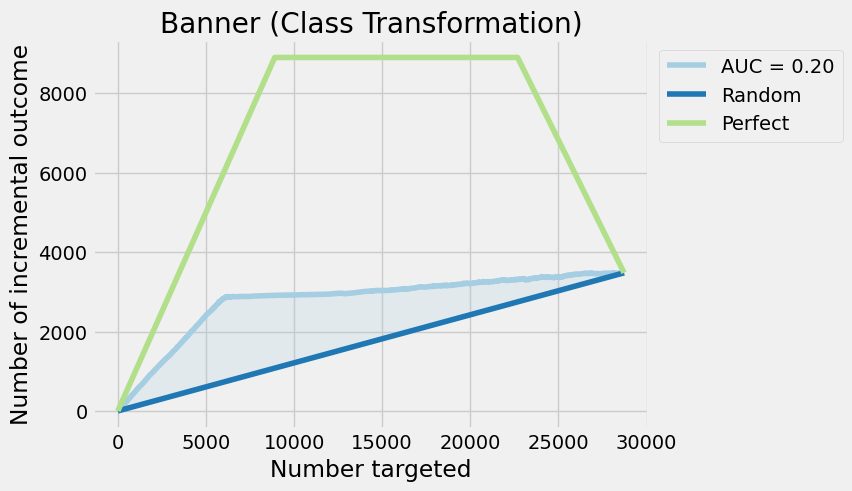

In [311]:
# баннеры
plot_qini_curve(y_true=y_test_banner_df,
                  uplift=pd.Series(uplift_ct_banner, index=X_test_banner_df.index),
                  treatment=X_test_banner_df['t_flag'])
plt.title('Banner (Class Transformation)')
plt.show()

In [312]:
# other
qini_auc_score(y_true=y_test_other_df,
               uplift=pd.Series(uplift_ct_other, index=X_test_other_df.index),
               treatment=X_test_other_df['t_flag'])

0.3023774138861753

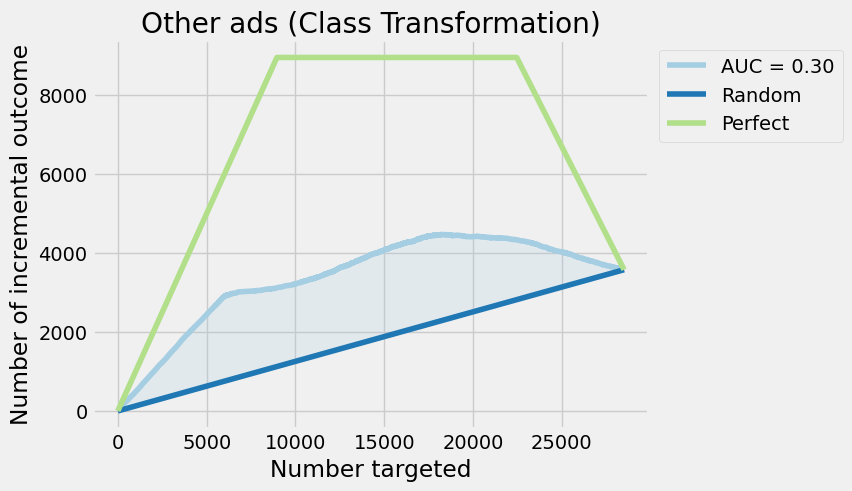

In [313]:
# other
plot_qini_curve(y_true=y_test_other_df,
                  uplift=pd.Series(uplift_ct_other, index=X_test_other_df.index),
                  treatment=X_test_other_df['t_flag'])
plt.title('Other ads (Class Transformation)')
plt.show()

In [314]:
# push
qini_auc_score(y_true=y_test_push_df,
               uplift=pd.Series(uplift_ct_push, index=X_test_push_df.index),
               treatment=X_test_push_df['t_flag'])

0.37132217969857423

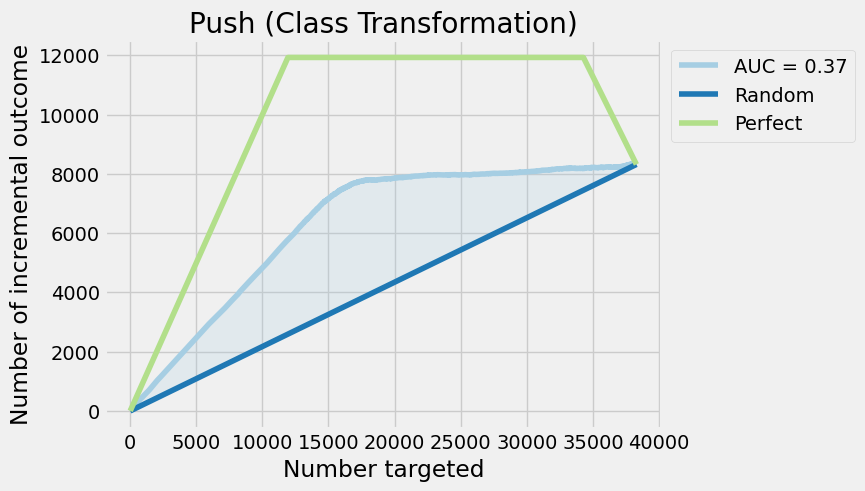

In [315]:
# push
plot_qini_curve(y_true=y_test_push_df,
                  uplift=pd.Series(uplift_ct_push, index=X_test_push_df.index),
                  treatment=X_test_push_df['t_flag'])
plt.title('Push (Class Transformation)')
plt.show()

### 3.6 UpliftRandomForest

In [316]:
from causalml.inference.tree import UpliftRandomForestClassifier

In [317]:
uplift_forest_banner = UpliftRandomForestClassifier(control_name='0', random_state=42)
uplift_forest_other = UpliftRandomForestClassifier(control_name='0', random_state=42)
uplift_forest_push = UpliftRandomForestClassifier(control_name='0', random_state=42)

Обработка столбца t_flag

In [318]:
# train
X_train_banner_df_cat = X_train_banner_df.copy()
X_train_other_df_cat = X_train_other_df.copy()
X_train_push_df_cat = X_train_push_df.copy()

# test
X_test_banner_df_cat = X_test_banner_df.copy()
X_test_other_df_cat = X_test_other_df.copy()
X_test_push_df_cat = X_test_push_df.copy()

In [319]:
X_train_banner_df_cat['t_flag'] = X_train_banner_df_cat['t_flag'].astype('str')
X_train_other_df_cat['t_flag'] = X_train_other_df_cat['t_flag'].astype('str')
X_train_push_df_cat['t_flag'] = X_train_push_df_cat['t_flag'].astype('str')

X_test_banner_df_cat['t_flag'] = X_test_banner_df_cat['t_flag'].astype('str')
X_test_other_df_cat['t_flag'] = X_test_other_df_cat['t_flag'].astype('str')
X_test_push_df_cat['t_flag'] = X_test_push_df_cat['t_flag'].astype('str')

Обучение случайного леса

In [320]:
uplift_forest_banner.fit(X=X_train_banner_df_cat.drop(columns='t_flag').values,
                         y=y_train_banner_df.values,
                         treatment=X_train_banner_df_cat['t_flag'].values)

uplift_forest_other.fit(X=X_train_other_df_cat.drop(columns='t_flag').values,
                         y=y_train_other_df.values,
                         treatment=X_train_other_df_cat['t_flag'].values)

uplift_forest_push.fit(X=X_train_push_df_cat.drop(columns='t_flag').values,
                         y=y_train_push_df.values,
                         treatment=X_train_push_df_cat['t_flag'].values)

In [321]:
uplift_banner_forest_predict = uplift_forest_banner.predict(X=X_test_banner_df_cat.drop(columns='t_flag').values)
uplift_other_forest_predict = uplift_forest_other.predict(X=X_test_other_df_cat.drop(columns='t_flag').values)
uplift_push_forest_predict = uplift_forest_push.predict(X=X_test_push_df_cat.drop(columns='t_flag').values)

In [322]:
# баннеры
qini_auc_score(y_true=y_test_banner_df,
               uplift=pd.Series(uplift_banner_forest_predict.flatten(), index=X_test_banner_df.index),
               treatment=X_test_banner_df['t_flag'])

0.19324527593669005

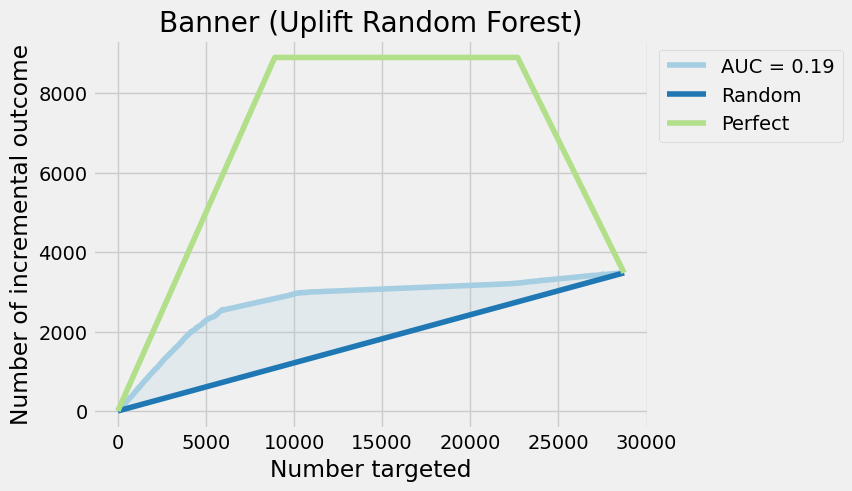

In [323]:
# баннеры
plot_qini_curve(y_true=y_test_banner_df,
                  uplift=pd.Series(uplift_banner_forest_predict.flatten(), index=X_test_banner_df.index),
                  treatment=X_test_banner_df['t_flag'])
plt.title('Banner (Uplift Random Forest)')
plt.show()

In [324]:
# other
qini_auc_score(y_true=y_test_other_df,
               uplift=pd.Series(uplift_other_forest_predict.flatten(), index=X_test_other_df.index),
               treatment=X_test_other_df['t_flag'])

0.19051987403003168

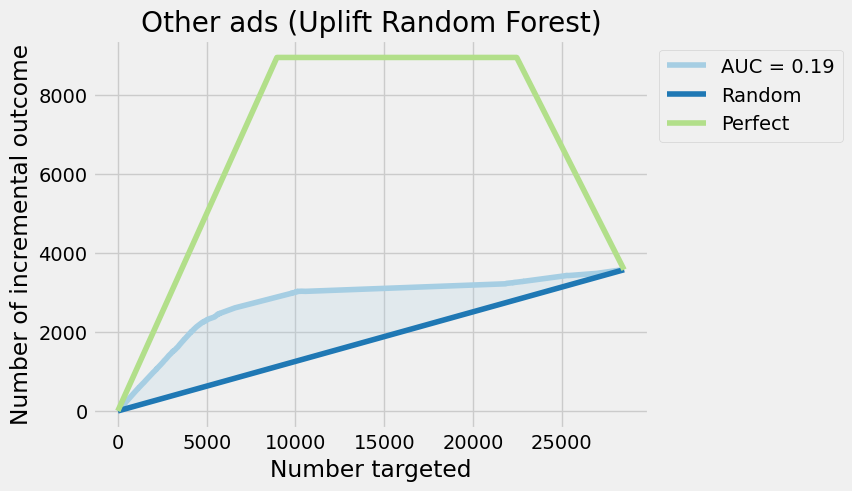

In [325]:
# other
plot_qini_curve(y_true=y_test_other_df,
                  uplift=pd.Series(uplift_other_forest_predict.flatten(), index=X_test_other_df.index),
                  treatment=X_test_other_df['t_flag'])
plt.title('Other ads (Uplift Random Forest)')
plt.show()

In [326]:
# push
qini_auc_score(y_true=y_test_push_df,
               uplift=pd.Series(uplift_push_forest_predict.flatten(), index=X_test_push_df.index),
               treatment=X_test_push_df['t_flag'])

0.36452663129633195

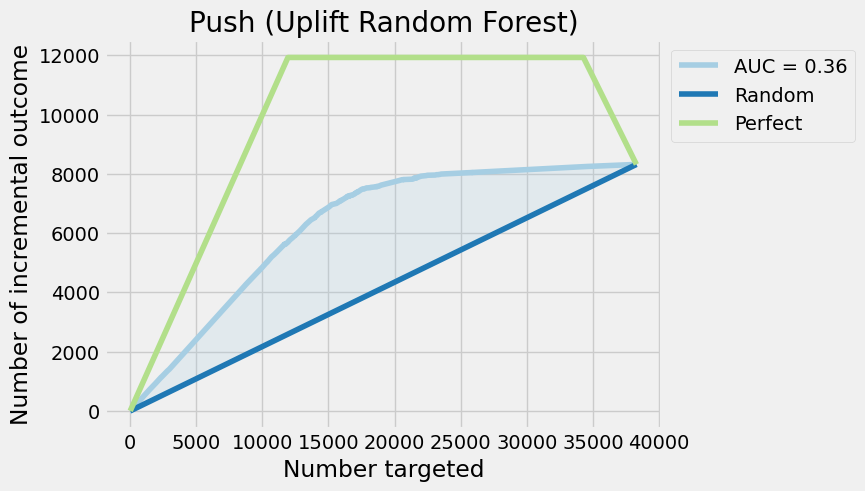

In [327]:
# push
plot_qini_curve(y_true=y_test_push_df,
                  uplift=pd.Series(uplift_push_forest_predict.flatten(), index=X_test_push_df.index),
                  treatment=X_test_push_df['t_flag'])
plt.title('Push (Uplift Random Forest)')
plt.show()

## Выводы

Лучшее качество у Class Transformation для всех видов коммуникаций

<h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

Поскольку необходимо спрогнозировать значения на март 2025 года, агрегаты пользователя должны быть за январь 2025 года (лаг 2 месяца)

In [328]:
features.query('report_dt < "2025-02-01" & report_dt >= "2025-01-01"')['report_dt'].unique()

<DatetimeArray>
['2025-01-31 00:00:00']
Length: 1, dtype: datetime64[ns]

Получается нужный период = '2025-01-31'

In [329]:
clients_to_score = features.query('report_dt < "2025-02-01" & report_dt >= "2025-01-01"')
clients_to_score

,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city
0,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,2025-01-31,1066338,26,Ufa
19,0.238281,-1.221378,0.338246,2.578613,-0.738267,-0.293309,-1.623151,-0.419945,-0.285695,2025-01-31,25872,42,Moscow
48,1.262071,-0.590011,-1.487096,-0.966672,2.740715,0.312791,-0.356535,-0.539563,1.401530,2025-01-31,4107442,28,Smolensk
66,-6.942073,0.107627,1.760962,4.424731,1.980637,0.238544,-1.329872,0.288694,-1.625620,2025-01-31,2047420,32,Moscow
67,-2.200147,0.694959,-1.620087,4.003986,0.808261,0.214216,-0.330887,-1.386118,1.525752,2025-01-31,1120643,22,Ufa
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759961,-0.852355,2.184957,-0.798753,1.716976,-0.200655,-1.836446,-0.407546,-1.819025,0.756988,2025-01-31,4034876,36,Moscow
2759983,1.343056,0.408401,-2.688668,-0.235793,-2.562377,-0.119657,-1.866503,0.273952,2.557688,2025-01-31,114148,31,Smolensk
2759991,-0.999208,0.527982,-2.094625,2.747209,2.326767,0.237984,-1.318151,-1.509199,1.989945,2025-01-31,143255,39,Smolensk
2759996,-1.970020,1.180142,-0.572525,1.052022,-0.654687,0.744590,-2.342623,-0.136155,0.582400,2025-01-31,132172,40,Moscow


Сбросим индекс и отдельно сохранием user_id с его индексом для дальнейшего мапинга скора и пользователя

In [330]:
index_user_id = clients_to_score.reset_index(drop=True)[['user_id']]
index_user_id.head()

,user_id
0,1066338
1,25872
2,4107442
3,2047420
4,1120643


Дропнем лишние столбцы, обработаем категориальный столбец с городом

In [331]:
cl_to_score_model_df = clients_to_score.drop(columns=['user_id', 'report_dt', 'x5'])
cl_to_score_model_df

,x1,x2,x3,x4,x6,x7,x8,x9,age,city
0,0.654343,-1.439286,-0.011475,2.039457,-0.977480,-0.768019,-1.044127,0.025673,26,Ufa
19,0.238281,-1.221378,0.338246,2.578613,-0.293309,-1.623151,-0.419945,-0.285695,42,Moscow
48,1.262071,-0.590011,-1.487096,-0.966672,0.312791,-0.356535,-0.539563,1.401530,28,Smolensk
66,-6.942073,0.107627,1.760962,4.424731,0.238544,-1.329872,0.288694,-1.625620,32,Moscow
67,-2.200147,0.694959,-1.620087,4.003986,0.214216,-0.330887,-1.386118,1.525752,22,Ufa
...,...,...,...,...,...,...,...,...,...,...
2759961,-0.852355,2.184957,-0.798753,1.716976,-1.836446,-0.407546,-1.819025,0.756988,36,Moscow
2759983,1.343056,0.408401,-2.688668,-0.235793,-0.119657,-1.866503,0.273952,2.557688,31,Smolensk
2759991,-0.999208,0.527982,-2.094625,2.747209,0.237984,-1.318151,-1.509199,1.989945,39,Smolensk
2759996,-1.970020,1.180142,-0.572525,1.052022,0.744590,-2.342623,-0.136155,0.582400,40,Moscow


In [332]:
# One-Hot Encoding для столбца 'category'
one_hot = pd.get_dummies(cl_to_score_model_df['city'], prefix='city')

# Удаление одного из столбцов (например, первого)
one_hot = one_hot.drop(one_hot.columns[0], axis=1)

# Присоединение результата к исходному DataFrame
df = pd.concat([cl_to_score_model_df, one_hot], axis=1)

df.drop(columns=['city'], inplace=True)

In [333]:
df

,x1,x2,x3,x4,x6,x7,x8,x9,age,city_Smolensk,city_Ufa
0,0.654343,-1.439286,-0.011475,2.039457,-0.977480,-0.768019,-1.044127,0.025673,26,False,True
19,0.238281,-1.221378,0.338246,2.578613,-0.293309,-1.623151,-0.419945,-0.285695,42,False,False
48,1.262071,-0.590011,-1.487096,-0.966672,0.312791,-0.356535,-0.539563,1.401530,28,True,False
66,-6.942073,0.107627,1.760962,4.424731,0.238544,-1.329872,0.288694,-1.625620,32,False,False
67,-2.200147,0.694959,-1.620087,4.003986,0.214216,-0.330887,-1.386118,1.525752,22,False,True
...,...,...,...,...,...,...,...,...,...,...,...
2759961,-0.852355,2.184957,-0.798753,1.716976,-1.836446,-0.407546,-1.819025,0.756988,36,False,False
2759983,1.343056,0.408401,-2.688668,-0.235793,-0.119657,-1.866503,0.273952,2.557688,31,True,False
2759991,-0.999208,0.527982,-2.094625,2.747209,0.237984,-1.318151,-1.509199,1.989945,39,True,False
2759996,-1.970020,1.180142,-0.572525,1.052022,0.744590,-2.342623,-0.136155,0.582400,40,False,False


Предскажем по Class Transformation

In [334]:
uplift_banner_ct_march = ct_banner.predict(df)
uplift_other_ct_march = ct_other.predict(df)
uplift_push_ct_march = ct_push.predict(df)

Сведем к одному датафрейму

In [335]:
data = {
    'channel': 'banner',
    'uplift': uplift_banner_ct_march
}

banner_stat = pd.DataFrame(data)
banner_stat

,channel,uplift
0,banner,0.163297
1,banner,0.030825
2,banner,0.967774
3,banner,0.182389
4,banner,0.075320
...,...,...
459995,banner,0.063317
459996,banner,0.991232
459997,banner,0.131098
459998,banner,0.039847


In [336]:
data = {
    'channel': 'other_ads',
    'uplift': uplift_other_ct_march
}

other_stat = pd.DataFrame(data)
other_stat

,channel,uplift
0,other_ads,0.163297
1,other_ads,0.030825
2,other_ads,0.967774
3,other_ads,0.182389
4,other_ads,0.075320
...,...,...
459995,other_ads,0.063317
459996,other_ads,0.991232
459997,other_ads,0.131098
459998,other_ads,0.039847


In [337]:
data = {
    'channel': 'push',
    'uplift': uplift_push_ct_march
}

push_stat = pd.DataFrame(data)
push_stat

,channel,uplift
0,push,0.163297
1,push,0.030825
2,push,0.967774
3,push,0.182389
4,push,0.075320
...,...,...
459995,push,0.063317
459996,push,0.991232
459997,push,0.131098
459998,push,0.039847


In [338]:
banner_user = banner_stat.merge(index_user_id, left_index=True, right_index=True)
other_user = other_stat.merge(index_user_id, left_index=True, right_index=True)
push_user = push_stat.merge(index_user_id, left_index=True, right_index=True)

In [339]:
push_user

,channel,uplift,user_id
0,push,0.163297,1066338
1,push,0.030825,25872
2,push,0.967774,4107442
3,push,0.182389,2047420
4,push,0.075320,1120643
...,...,...,...
459995,push,0.063317,4034876
459996,push,0.991232,114148
459997,push,0.131098,143255
459998,push,0.039847,132172


In [340]:
merged = pd.concat([banner_user, other_user, push_user])
merged

,channel,uplift,user_id
0,banner,0.163297,1066338
1,banner,0.030825,25872
2,banner,0.967774,4107442
3,banner,0.182389,2047420
4,banner,0.075320,1120643
...,...,...,...
459995,push,0.063317,4034876
459996,push,0.991232,114148
459997,push,0.131098,143255
459998,push,0.039847,132172


In [347]:
data = {
    'user_id': merged['user_id'].values,
    'report_dt': '2025-01-31',
    'channel': merged['channel'].values,
    'uplift': [round(x, 2) for x in merged['uplift'].values]
    }

final_answer = pd.DataFrame(data)

Финальный ответ

In [348]:
final_answer

,user_id,report_dt,channel,uplift
0,1066338,2025-01-31,banner,0.16
1,25872,2025-01-31,banner,0.03
2,4107442,2025-01-31,banner,0.97
3,2047420,2025-01-31,banner,0.18
4,1120643,2025-01-31,banner,0.08
...,...,...,...,...
1379995,4034876,2025-01-31,push,0.06
1379996,114148,2025-01-31,push,0.99
1379997,143255,2025-01-31,push,0.13
1379998,132172,2025-01-31,push,0.04


Оценим распределения uplift по коммуникациям

In [349]:
final_answer.query('channel == "banner"')['uplift'].describe()

count    460000.000000
mean          0.471003
std           0.372395
min          -0.360000
25%           0.110000
50%           0.360000
75%           0.890000
max           1.000000
Name: uplift, dtype: float64

In [ ]:
final_answer.groupby('channel').agg(min_uplift=('uplift', 'mean'),
                                    mean_uplift=('uplift', 'mean'),
                                    median_uplift=('uplift', 'median'),
                                    max_uplift=('uplift', 'max'),
                                    std_uplift=('uplift', 'std'),
                                    )
# распределения одинаковые

,min_uplift,mean_uplift,median_uplift,max_uplift,std_uplift
channel,,,,,
banner,0.471003,0.471003,0.36,1.0,0.372395
other_ads,0.471003,0.471003,0.36,1.0,0.372395
push,0.471003,0.471003,0.36,1.0,0.372395


<Axes: xlabel='uplift', ylabel='Count'>

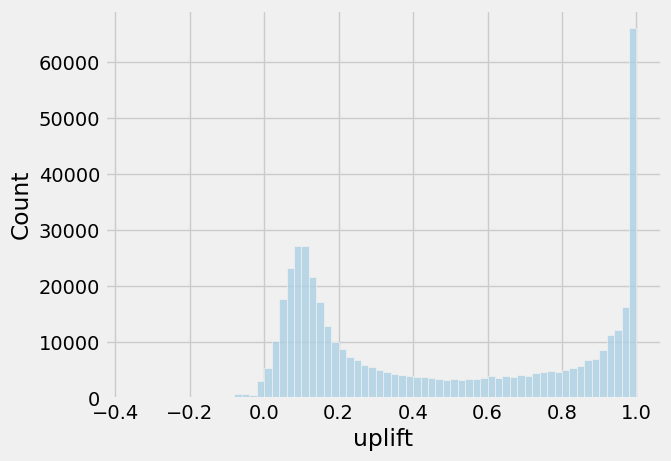

In [345]:
sns.histplot(final_answer.query('channel == "banner"').uplift)

Распределение имеет 2 моды: 1-ая в области нуля; 2-ая - в единице.

In [351]:
# пользователи для рассылки в марте
# 89 перцентиль
percentile_89 = final_answer['uplift'].quantile(0.89)
users_to_communicate = final_answer[final_answer['uplift'] > percentile_89]

### ваши выводы здесь

Было проведено сравнение нескольких моделей для прогнозирования значения uplift - лучшей оказалась Class Transofrmation с AUC (banner = 0.2, other_ads = 0.3, push = 0.37). \
\
По ней было спрогнозировано значение uplift для агрегированных показателй пользователей за январь (то есть для марта). \
\
Исходя из распределения uplift, предалагаю делать рассылку пользователям с вероятностью больше чем у 75% пользователей, то есть 89%. Для большого числа пользователей uplift = 100%, поэтому считаю оправданным захватить правый край распределения, проигнорировав низкий промежуток от 20% до 80%


In [ ]:
# пользователи для коммуникации по разным видам коммуникации
users_to_communicate

,user_id,report_dt,channel,uplift
8,1091552,2025-01-31,banner,0.99
26,39725,2025-01-31,banner,0.99
37,4106668,2025-01-31,banner,0.99
44,4018424,2025-01-31,banner,0.99
46,2060323,2025-01-31,banner,0.99
...,...,...,...,...
1379980,103540,2025-01-31,push,0.99
1379983,2058416,2025-01-31,push,0.99
1379986,74534,2025-01-31,push,0.99
1379993,2036394,2025-01-31,push,0.99
